<a href="https://colab.research.google.com/github/datagf/forecasts_for_product_demand/blob/main/analytics2GO_data_scientist_evaluation_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

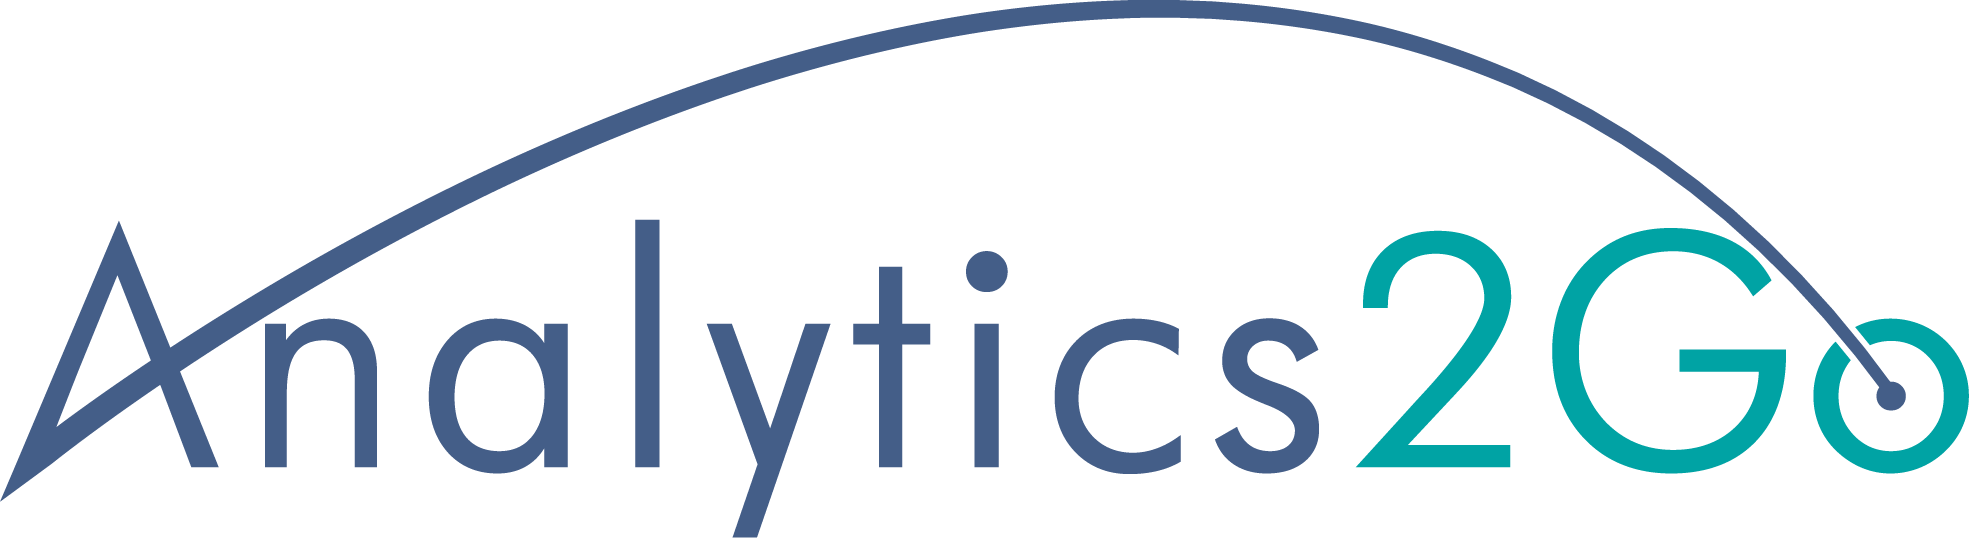

# Data Scientist Exercise
*by Gilberto Filho*

### This Notebook aims to offer insights based on the data provided by the Forecasts for Product Demand Kaggle dataset: https://www.kaggle.com/felixzhao/productdemandforecasting

<a name='index'></a>
### Index
- **Introduction**
  - [Objectives](#objectives)
  - [Data](#data)
- **Data Knowlegement and Data Wrangling**
  - [Installing and updating libraries](#inst_lib)
  - [Gathering libraries](#libraries)
  - [Generating requirements](#requirements)
  - [Data ingestion](#loading)
  - [Data exploration and understanding](#data_exp_und)
  - [Functions definition](#func_def)
  - [Product demand analysis](#prod_demand_analysis)
  - [Time series study](#time_series_study)
  - [Simple moving average x Exponential weighted moving average - DAILY](#sma_ewma_daily)
  - [Simple moving average x Exponential weighted moving average - WEEKLY](#sma_ewma_weekly)
  - [Simple moving average x Exponential weighted moving average - MONTHLY](#sma_ewma_monthly)
  - [Check stationarity](#check_stationarity)
  - [Lag plot](#lag_plot)
  - [Autocorrelation and partial autocorrelation plots](#autocorr_partialautocorr)
  - [Choosen product - dataframe study and preparation](#choosen_product)
- **Forecasting**
  - [Splitting product 1359 (warehouse J) time series for forecasting studies](#forecasting_studies)
  - [Forecasting - naïve (benchmarking)](#forecasting_benchmarking)
  - [Forecasting - ARIMA](#forecasting_arima)
  - [Forecasting - Auto ARIMA](#forecasting_auto_arima)
  - [Smoothing moving average - 3 days window prediction for one year](#forecasting_sma)
  - [Forecasting - XGBoost](#forecasting_xboost)
  - [Forecasting - Analysis](#forecasting_analysis)

<a name='objectives'></a>
### Key Objectives and Deliverables are:

1. **Explore the data** – be creative and pay attention to the details.
2. **Time Series Study** – provide a better understanding of the time series characteristics.
3. **Create predictives models** – provide some demand forecasting based on discoveries along the data exploration and time series study.

<a name='data'></a>
### The Data

- `Product_Code` - The product name encoded.
- `Warehouse` - Warehouse name encoded.
- `Product_Category` - Product Category for each Product_Code encoded.
- `Date` - The date customer needs the product.
- `Order_Demand` - single order qty.

<a name='inst_lib'></a>
### Installing and updating libraries

In [1]:
!pip install -U pmdarima

In [2]:
!pip install -U scikit-learn

In [3]:
!pip install -U permetrics

In [4]:
# change directory on google drive
%cd /content/drive/MyDrive/analytics2go_data_scientist_exercise

/content/drive/MyDrive/analytics2go_data_scientist_exercise


<a name='libraries'></a>
### Gathering libraries

In [5]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import statsmodels.api as sm
import fbprophet as Prophet
import cv2
import pmdarima as pm
import warnings
import datetime as dt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as r2
from math import sqrt
from permetrics.regression import Metrics
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from IPython.display import clear_output
from pandas.plotting import lag_plot, autocorrelation_plot, register_matplotlib_converters

from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline
%config Completer.use_jedi = False


<a name='requirements'></a>
### Generating requirements

In [6]:
!pip freeze > requirements.txt

[>>> Click here to go to index <<<](#index)

<a name='loading'></a>
### Data ingestion

In [7]:
def data_ingestion(table_path):
    df = pd.read_csv(table_path, parse_dates = ['Date'])
    df.sort_values(by=['Date'], inplace=True)
    return df
    

In [8]:
df = data_ingestion('historical_product_demand.csv')
df.head()


Product_Code Warehouse Product_Category       Date Order_Demand
44799  Product_0965    Whse_A     Category_006 2011-01-08           2 
72252  Product_1724    Whse_A     Category_003 2011-05-31         108 
8431   Product_1521    Whse_S     Category_019 2011-06-24       85000 
8432   Product_1521    Whse_S     Category_019 2011-06-24        7000 
72669  Product_1507    Whse_C     Category_019 2011-09-02        1250

[>>> Click here to go to index <<<](#index)

<a name='data_exp_und'></a>
### Data exploration and understanding

In [9]:
def data_exploration(df):
    print('--- DATA FRAME INFO ---\n')
    print(df.info())
    print('\n--- DATA FRAME DATA TYPES ---\n')
    print(df.dtypes)
    print('\n--- DATA FRAME NULL VALUES ---\n')
    print(df.isnull().any())
    print('\n--- PERCENTAGE OF NULL DATA FRAME VALUES ---\n')
    print(df.isnull().sum() * 100 / len(df))
    print('\n--- DATA FRAME ORDER DEMAND DESCRIPTION - NUMERICAL VALUES ---\n')
    print(df['Order_Demand'].describe())
    print('\n--- DATA FRAME ORDER DEMAND DESCRIPTION - CATEGORICAL VALUES ---\n')
    print(df.astype('object').describe().transpose())
    print('\n--- DATE COLUMN ---\n')
    print('First date:', df.Date.min())
    print('Last date:', df.Date.max())    
    print('Delta date:', df.Date.max() - df.Date.min())
    print('\n--- PRODUCT_CATEGORY COLUMN ---\n')
    print('Unique product categories:\n\n',df.Product_Category.unique())
    print('\n >>> Total unique product categories:',df.Product_Category.unique().size)
    print('\n--- PRODUCT_CODE COLUMN ---\n')
    print('Unique products:\n\n',df.Product_Code.unique())
    print('\n >>> Total unique products:',df.Product_Code.unique().size)
    print('\n--- WAREHOUSE COLUMN ---\n')
    print('Unique warehouses:\n\n',df.Warehouse.unique())
    print('\n >>> Total unique warehouses:',df.Warehouse.unique().size)


In [10]:
# generate data exploration report
data_exploration(df)


--- DATA FRAME INFO ---

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 44799 to 995794
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1048575 non-null  object        
 1   Warehouse         1048575 non-null  object        
 2   Product_Category  1048575 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1048575 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 48.0+ MB
None

--- DATA FRAME DATA TYPES ---

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

--- DATA FRAME NULL VALUES ---

Product_Code        False
Warehouse           False
Product_Category    False
Date                 True
Order_Demand        False
dtype: bool

--- PE

In [11]:
# remove all rows with na's
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True)


Product_Code Warehouse Product_Category       Date Order_Demand
0        Product_0965    Whse_A     Category_006 2011-01-08           2 
1        Product_1724    Whse_A     Category_003 2011-05-31         108 
2        Product_1521    Whse_S     Category_019 2011-06-24       85000 
3        Product_1521    Whse_S     Category_019 2011-06-24        7000 
4        Product_1507    Whse_C     Category_019 2011-09-02        1250 
...               ...       ...              ...        ...          ...
1037331  Product_1710    Whse_J     Category_026 2017-01-06          15 
1037332  Product_1359    Whse_J     Category_019 2017-01-06      100000 
1037333  Product_0250    Whse_C     Category_007 2017-01-09         148 
1037334  Product_1904    Whse_C     Category_019 2017-01-09        4000 
1037335  Product_0471    Whse_C     Category_015 2017-01-09          30 

[1037336 rows x 5 columns]

In [12]:
# change order dmand format
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")
df['Order_Demand'] = df['Order_Demand'].str.strip()

# since the "()" has been removed, we could change the data type
df['Order_Demand'] = df['Order_Demand'].astype('int64')


In [13]:
# order demand analysis function definition
def order_demand_analysis(df):
    print('--- ORDER DEMAND SUM ---\n')
    print(df['Order_Demand'].sum())
    print('\n--- ORDER DEMAND DATA TYPE ---\n')
    print(df.Order_Demand.dtypes)
    print('\n--- ORDER DEMAND DESCRIPTION - NUMERICAL VALUES ---\n')
    print(df.Order_Demand.describe())


In [14]:
# generate order demand analysis report
order_demand_analysis(df)


--- ORDER DEMAND SUM ---

5134173931

--- ORDER DEMAND DATA TYPE ---

int64

--- ORDER DEMAND DESCRIPTION - NUMERICAL VALUES ---

count    1.037336e+06
mean     4.949384e+03
std      2.907344e+04
min      0.000000e+00
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: Order_Demand, dtype: float64


[>>> Click here to go to index <<<](#index)

<a name='func_def'></a>
### Functions definitions

In [15]:
# return a list of dataframes by year
def list_dfs(df):
    df_2011 = df[(df['Date']>='2011-01-01') & (df['Date']<='2012-01-01')].sort_values('Date', ascending=True).copy()
    df_2012 = df[(df['Date']>='2012-01-01') & (df['Date']<='2013-01-01')].sort_values('Date', ascending=True).copy()
    df_2013 = df[(df['Date']>='2013-01-01') & (df['Date']<='2014-01-01')].sort_values('Date', ascending=True).copy()
    df_2014 = df[(df['Date']>='2014-01-01') & (df['Date']<='2015-01-01')].sort_values('Date', ascending=True).copy()
    df_2015 = df[(df['Date']>='2015-01-01') & (df['Date']<='2016-01-01')].sort_values('Date', ascending=True).copy()
    df_2016 = df[(df['Date']>='2016-01-01') & (df['Date']<='2017-01-01')].sort_values('Date', ascending=True).copy()
    df_2017 = df[(df['Date']>='2017-01-01') & (df['Date']<='2018-01-01')].sort_values('Date', ascending=True).copy()
    list_dfs = [df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017]
    return list_dfs

# plot demand by year
def plot_demand_by_date(list_dfs):    
    for i in range(0, len(list_dfs)):
        rcParams['figure.figsize'] = 9,6
        sns.lineplot(x=list_df_by_year[i]['Date'], y=list_df_by_year[i]['Order_Demand'])
        plt.show()
        print('')

# return demand per year in ascending order
def year_demand(df):
    df_year = pd.DataFrame()
    df['Year'] = df['Date'].dt.year
    df_year['Demand'] = df.groupby('Year')['Order_Demand'].sum()
    df_year['Orders'] = df['Year'].value_counts()
    df_year['Demand per Order'] = (df_year['Demand'] / df_year['Orders']).round(decimals=2)
    return df_year.sort_index(ascending=True)

# adjust dates for analysis purposes
def adjusting_dates(df):
    df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)
    dates1 = [pd.to_datetime(date) for date in df['Date']]
    dates1.sort()
    print("Start Date: {}".format(dates1[0]))
    print("Final Date: {}".format(dates1[-1]))
    n_days = dates1[-1] - dates1[0]
    print("Delta Date: {}".format(n_days))
    return df

# warehouse shipping sorted by orders in a descending mode
def warehouse_demand(df):
    df_warehouse  = pd.DataFrame()
    df_warehouse['Orders']=df['Warehouse'].value_counts()
    df_warehouse['Demand']=df.groupby('Warehouse')['Order_Demand'].sum()
    df_warehouse['Demand/Order'] = df_warehouse['Demand'] / df_warehouse['Orders']
    df_warehouse['Demand/Order'] = df_warehouse['Demand/Order'].round(decimals=2)
    return df_warehouse.sort_values('Orders', ascending = False)

# demand per year per warehouse
def warehouse_demand_year(df):
    df_warehouse2 = df[['Year', 'Warehouse', 'Order_Demand']].groupby(['Year', 'Warehouse'], as_index=False).count()
    df_warehouse2 = df_warehouse2.pivot(index='Year', columns='Warehouse', values='Order_Demand')
    df_warehouse2['Total'] = df_warehouse2.sum(axis=1)
    return df_warehouse2

# return wharehouse list
def list_dfs_warehouses(df):
    df_warehouse_ts = df[['Warehouse', 'Date', 'Order_Demand']].groupby(['Date', 'Warehouse'], as_index=False).sum()
    df_Whse_S = df_warehouse_ts[df_warehouse_ts['Warehouse'] == 'Whse_S']
    df_Whse_A = df_warehouse_ts[df_warehouse_ts['Warehouse'] == 'Whse_A']
    df_Whse_C = df_warehouse_ts[df_warehouse_ts['Warehouse'] == 'Whse_C']
    df_Whse_J = df_warehouse_ts[df_warehouse_ts['Warehouse'] == 'Whse_J']
    list_dfs = [df_Whse_S, df_Whse_A, df_Whse_C, df_Whse_J]
    return list_dfs

# plot wareshouse list
def line_plot_warehouses_data(list_dfs, figsizex, figsizey):    
    for i in range(0, len(list_dfs)):
        rcParams['figure.figsize'] = figsizex,figsizey
        sns.lineplot(x=list_dfs_warehouses[i]['Date'], 
                     y=list_dfs_warehouses[i]['Order_Demand']).set_title(list_dfs_warehouses[i]['Warehouse'].iloc[0])
        plt.show()
        print('')

In [16]:
# order demand per warehouse
def order_demand_whse(df, figsizex=12, figsizey=6):

    # sum total demand per whareshouse
    df_whse = df
    df_whse = df_whse.groupby(['Warehouse']).sum()

    # plot results parameters
    fig0, ax = plt.subplots(figsize=(figsizex,figsizey))

    ax.bar(df_whse.index, df_whse.Order_Demand, width = 0.5)
    ax.set_title('\nTOTAL ORDER DEMAND PER WAREHOUSE\n', fontsize=15)
    ax.set_ylabel('\nOrder Demand\n', fontsize = 14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)


# order demand per product category
def order_demand_whse_cat(df, title, warehouse, axes):

    warehouse_cat = df.groupby(['Warehouse','Product_Category']).sum()

    # plot result parameters    
    title = '\n'+title
    axes.bar(warehouse_cat.loc[warehouse]['Order_Demand'].index,
             warehouse_cat.loc[warehouse]['Order_Demand'])
    axes.set_title(title, fontsize=16)
    axes.tick_params(labelrotation=90)
    axes.set_ylabel('\nOrder Demand\n', fontsize=14)
    axes.tick_params(axis='x', labelsize=12)
    axes.tick_params(axis='y', labelsize=12)


# order demand per product code
def order_demand_whse_cat_prod(df, title, warehouse, axes):

    warehouse_product = df.groupby(['Warehouse','Product_Category', 'Product_Code']).sum()

    # plot result parameters    
    title = '\n'+title
    axes.bar(warehouse_product.loc[warehouse]['Order_Demand'].index, warehouse_product.loc[warehouse]['Order_Demand'])
    axes.set_title(title, fontsize=16)
    axes.tick_params(labelrotation=90)
    axes.set_ylabel('\nOrder Demand\n', fontsize=14)
    axes.tick_params(axis='x', labelsize=12)
    axes.tick_params(axis='y', labelsize=12)

# top 5 products order demand
def order_demand_per_prod_top5(df, title, figsizex=12, figsizey=6):

    warehouses_products_demand_top5 = df.groupby('Product_Code')['Order_Demand'].sum().sort_values(ascending=False).to_frame().head()

    # plot result parameters    
    title = '\n'+title+'\n'
    rcParams['figure.figsize'] = figsizex, figsizey
    ax = warehouses_products_demand_top5.plot.bar()
    ax.set_title(title, fontsize=16)
    ax.tick_params(labelrotation=90)
    ax.set_ylabel('\nOrder Demand\n', fontsize=14)
    ax.set_xlabel('\nProduct Code\n', fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)


In [17]:
# boxpot distribution plot
def visual_warehouses_boxplot(df, figsizex=12, figsizey=12):
    # figure size in inches
    rcParams['figure.figsize'] = figsizex, figsizey
    fig, axes = plt.subplots(2, 1)
    fig.subplots_adjust(hspace=.3)

    #Regular Data
    fig1 = sns.boxplot(df['Warehouse'], df['Order_Demand'], ax = axes[0]).set_title('REGULAR DATA')
    plt.xlabel('Wharehouses')
    plt.ylabel('Order Demand')

    #Data with Log Transformation
    fig2 = sns.boxplot(df['Warehouse'], np.log1p(df['Order_Demand']), ax = axes[1]).set_title('DATA WITH LOG TRANSFORMATION')
    plt.xlabel('Wharehouses')
    plt.ylabel('Order Demand Transformed')

# wharehouse informations
def df_warehouse_info(df):
    df_warehouse_date_pivot = pd.pivot_table(df, index='Date',
                                             columns='Warehouse',
                                             values='Order_Demand',
                                             fill_value=0)
    print('--- DATA FRAME INFO ---\n')
    print(df_warehouse_date_pivot.info())
    print('\n--- ZERO DEMANDS PERCENTAGE ---\n')
    print((1- (df_warehouse_date_pivot.astype(bool).sum(axis=0) / df_warehouse_date_pivot.count(axis=0)))*100)
    print('\n--- DATA FRAME PIVOTED BY DATE ---\n')
    return df_warehouse_date_pivot
    

In [18]:
# demand per day function
def demand_by_date(df):    
    demand_by_date = df.groupby('Date')['Order_Demand'].sum().reset_index().copy()

    # index the date
    demand_by_date = demand_by_date.set_index('Date').copy()
    
    # check the index
    print('--- DEMAND PER DAY DATA FRAME INFO ---\n')
    print(demand_by_date.index)
    print('\n--- DEMAND PER DAY DATA FRAME ---\n')
    return demand_by_date

# demand by year plot function
def plot_demand_by_year_month(df, figsizex=12, figsizey=6):
    title = 'YEARLY DEMAND ORDER'
    fig1 = df['Order_Demand'].resample('A').sum().plot.bar(figsize=(figsizex,figsizey), title=title)
    fig1.set(xlabel='')  
    plt.show()    
    print('')
    title = 'MONTHLY DEMAND ORDER'
    fig2 = df_demand_by_date['Order_Demand'].resample('M').mean().plot.bar(figsize=(figsizex,figsizey), title=title)
    fig2.set(xlabel='')
    plt.show()


In [19]:
# y periods function
def y_period(df, periods):
    y_list = []
    for item in periods:
        y_period = df['Order_Demand'].resample(item).mean()
        y_list.append(y_period)      
    return y_list

# time series period mean plot function
def df_plot_period_ts(y_period, w_period1, w_period2):
    plt.rcParams['figure.figsize'] = (15, 6)
    plt.plot(y_period, '#1f78b4', label='period')
    plt.plot(y_period.rolling(window=w_period1).mean(), '#e1812b', label=f'{w_period1} period(s) mean')
    plt.plot(y_period.rolling(window=w_period2).mean(), '#bf3d3d', label=f'{w_period2} period(s) mean')
    plt.legend(loc='best')

# plot seasonal function
def plotseasonal(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

# plot seasonal decomposition function
def plotseasonal_decomposition(dec_day, dec_week, dec_month, figsizex=18, figsizey=9):
    fig, axes = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(figsizex, figsizey))
    axes[0,0].set_title('Daily', pad=21)
    axes[0,1].set_title('Weekly', pad=21)
    axes[0,2].set_title('Monthly', pad=21)
    plotseasonal(dec_day, axes[:,0])
    plotseasonal(dec_week, axes[:,1])
    plotseasonal(dec_month, axes[:,2])
    plt.tight_layout()
    plt.show()


In [20]:
# simple moving average and exponential weighted moving average function 
def SMA_EWMA(data, window1, window2, span1, span2):
    y = pd.DataFrame(data).copy()
    y.dropna(inplace=True)
    y.index = pd.to_datetime(data.index)
    y['Window1'] = y['Order_Demand'].rolling(window=window1).mean()
    y['Window2'] = y['Order_Demand'].rolling(window=window2).mean()
    y['Span1'] = y['Order_Demand'].ewm(span=span1).mean().shift(-1)
    y['Span2'] = y['Order_Demand'].ewm(span=span2).mean().shift(-1)
    return y['Window1'], y['Window2'], y['Span1'], y['Span2']
    

In [21]:
# test stationarity function
def test_stationarity(timeseries, figsizex=12, figsizey=6):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics    
    orig = plt.plot(timeseries, color='#1f78b4',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')  
    plt.rcParams['figure.figsize'] = (figsizex,figsizey)  
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput.to_string())
    
    if dftest[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


In [22]:
# pass the lag argument and plot the values.
# when lag=1 the plot is essentially data[:-1] vs. data[1:]
# plot our ts_data_load set

def lagplot(df, lag=8, figsizex=12, figsizey=6):

    plt.rcParams['figure.figsize'] = (figsizex,figsizey)
    for i in range(1,(lag + 1)):
        ax = plt.subplot(240 + i)
        lag_plot(df, lag=i)
    plt.show()


In [23]:
# arima order function
def order_aic(data, order, sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
            try:
                model_fit = model.fit()
                c_order = f'p{p} d{d} q{q}'
                aic = model_fit.aic
                bic = model_fit.bic
                order_list.append(c_order)
                aic_list.append(aic)
                bic_list.append(bic)
            except:
                pass
            result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
            result_df.sort_values(sort, inplace=True)
    return result_df
    

[>>> Click here to go to index <<<](#index)

<a name='prod_demand_analysis'></a>
### Product demand analysis

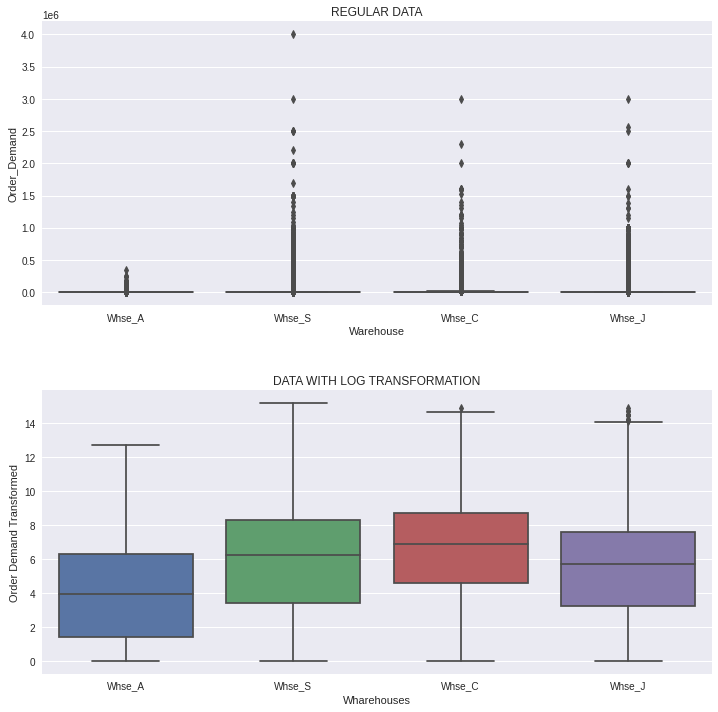

In [24]:
visual_warehouses_boxplot(df)


**OBSERVATION:** data log transformation was necessary to show a meaningful box plot information.

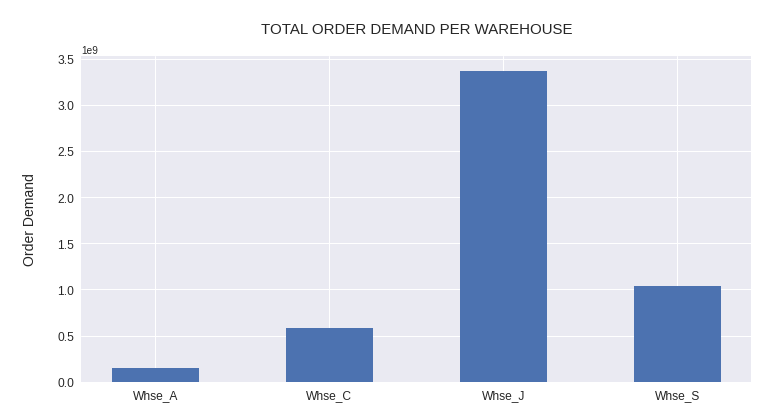

In [25]:
order_demand_whse(df)


**OBSERVATION:** the most important warehouse in terms of order demand is Warehouse J.

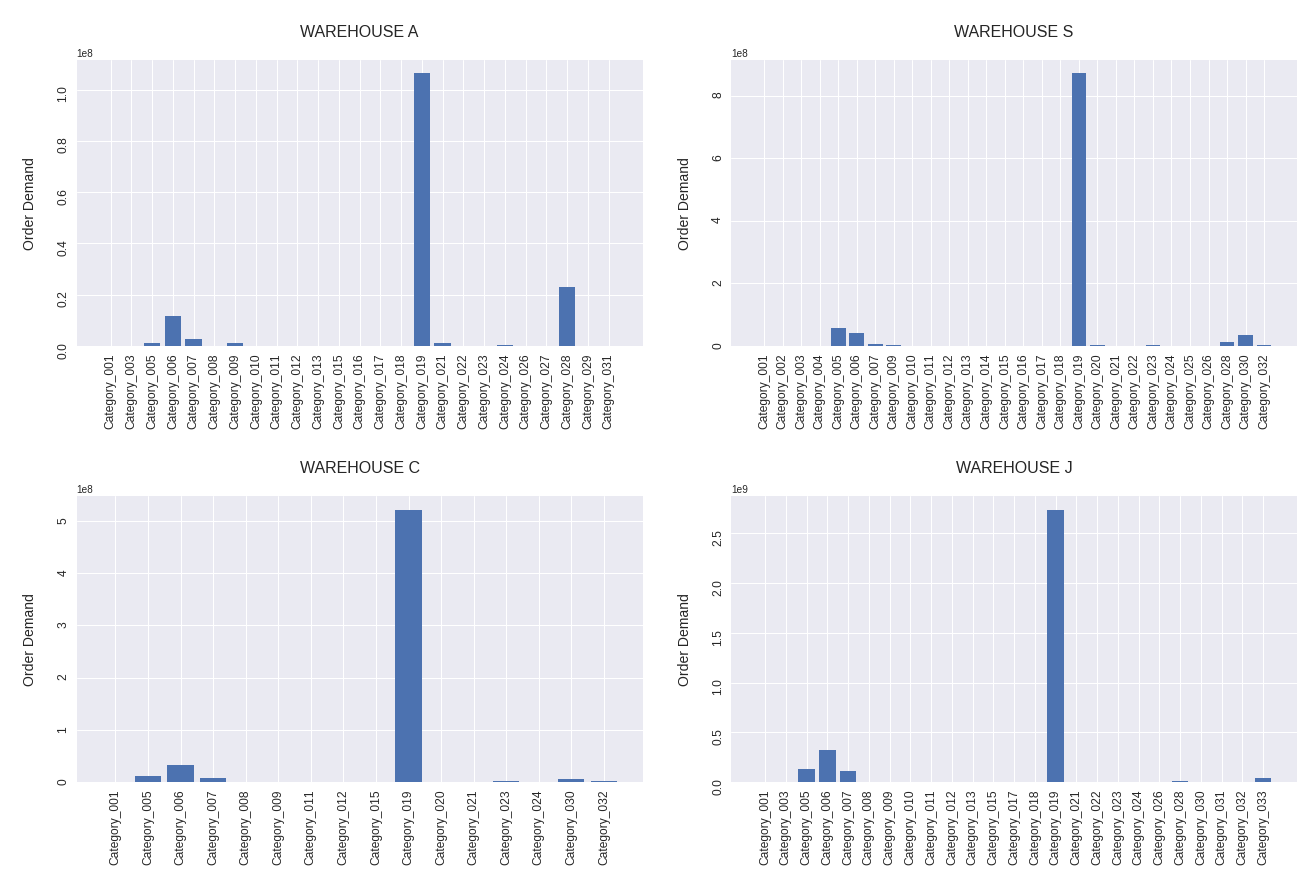

In [26]:
fig1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,12), constrained_layout=True)
order_demand_whse_cat(df, 'WAREHOUSE A\n', 'Whse_A', ax1)
order_demand_whse_cat(df, 'WAREHOUSE S\n', 'Whse_S', ax2)
order_demand_whse_cat(df, 'WAREHOUSE C\n', 'Whse_C', ax3)
order_demand_whse_cat(df, 'WAREHOUSE J\n', 'Whse_J', ax4)


**OBSERVATION:** the most important Product Category in terms of order demand is Category 019.

In [27]:
# warehouse J data frame
df_whse_J = df[(df['Warehouse'] == 'Whse_J')]
df_whse_J


Product_Code Warehouse Product_Category       Date  Order_Demand
107159   Product_0138    Whse_J     Category_007 2011-11-22          1852
107158   Product_0138    Whse_J     Category_007 2011-11-22           188
93055    Product_0504    Whse_J     Category_015 2011-12-05             1
107170   Product_0138    Whse_J     Category_007 2011-12-05           240
37485    Product_1699    Whse_J     Category_026 2011-12-07             1
...               ...       ...              ...        ...           ...
920140   Product_0025    Whse_J     Category_005 2017-01-06           500
920154   Product_0025    Whse_J     Category_005 2017-01-06           700
920147   Product_1970    Whse_J     Category_005 2017-01-06          2000
1009604  Product_1710    Whse_J     Category_026 2017-01-06            15
921328   Product_1359    Whse_J     Category_019 2017-01-06        100000

[764447 rows x 5 columns]

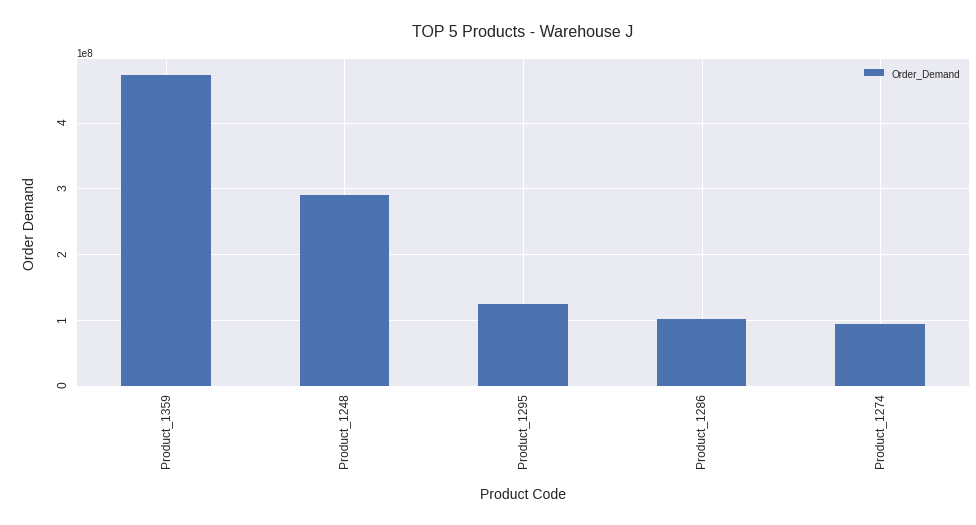

In [28]:
order_demand_per_prod_top5(df_whse_J, 'TOP 5 Products - Warehouse J', 16, 6)


**OBSERVATION:** the most important Product in terms of order demand is Product 1359 and this will be the choosen one to forecasting.

### Year Demand Analysis

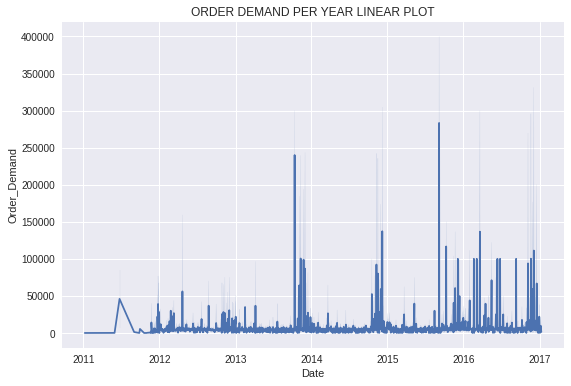

In [29]:
# demand analysis linear plotting
rcParams['figure.figsize'] = 9,6
sns.lineplot(x=df['Date'], y=df['Order_Demand']).set(title='ORDER DEMAND PER YEAR LINEAR PLOT');


**OBSERVATION:** years 2011 and 2017 apparently show non regular demand distribution, this may impact future forecasting.

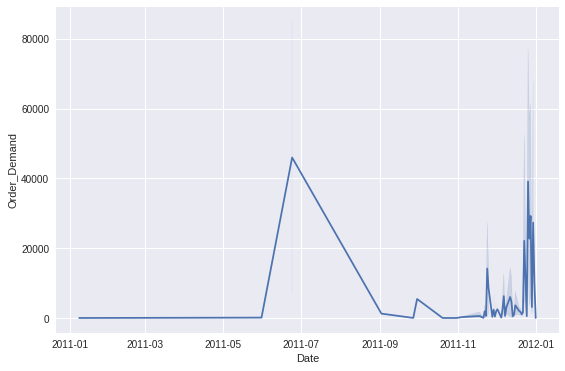

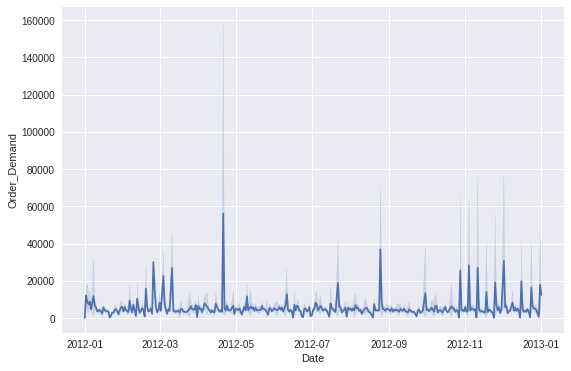

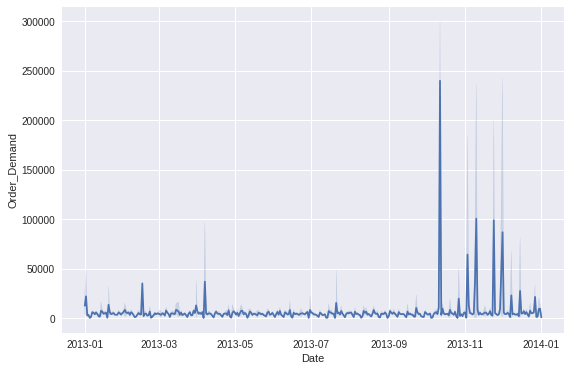

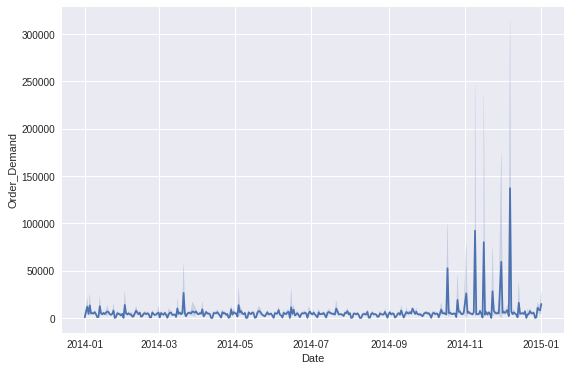

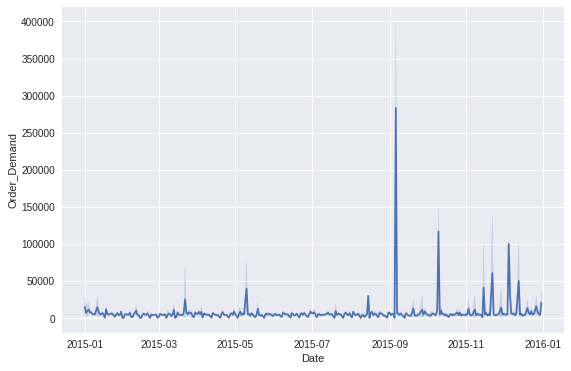

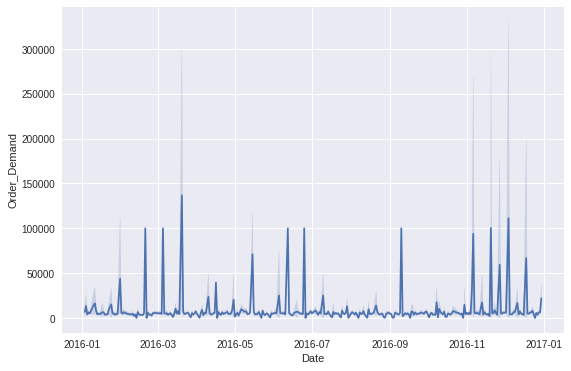

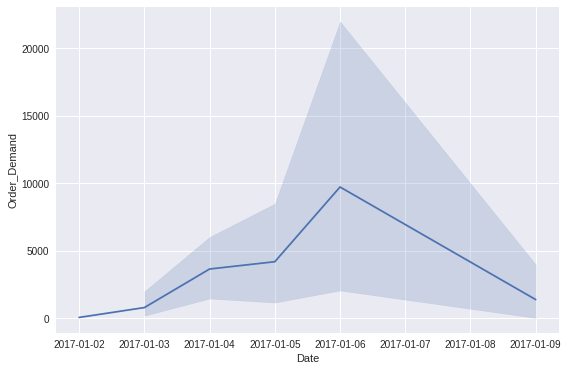

In [30]:
# demand analysis linear plotting per year
list_df_by_year = list_dfs(df)
plot_demand_by_date(list_df_by_year)


**OBSERVATION:** after spliting the plots by year it is clear that years 2011 and 2017 should be dropped because they did not present a regular demand distribution and this may affect the forecasting process.

In [31]:
# demand analysis table per year
year_demand(df)


Demand  Orders  Demand per Order
Year                                      
2011     8363894     640          13068.58
2012   949259991  203635           4661.58
2013  1014087922  218298           4645.43
2014  1071178367  216404           4949.90
2015  1099398391  209661           5243.70
2016   991590399  188645           5256.38
2017      294967      53           5565.42

**OBSERVATION:** there are few orders and demand in 2011 and 2017. In 2011 the demand per order ratio is the biggest one because the orders were concentraded from june to september. In 2017 there are only a little data about orders demand. 2011 should be dropped because the unnusual order demand and poor data. 2017 should be dropped because poor data.

In [32]:
# data adjustments according to observation above
df = adjusting_dates(df)
df.head()


Start Date: 2012-01-01 00:00:00
Final Date: 2016-12-30 00:00:00
Delta Date: 1825 days 00:00:00


Product_Code Warehouse Product_Category       Date  Order_Demand  Year
130870  Product_2166    Whse_S     Category_024 2012-01-01             2  2012
77217   Product_1343    Whse_S     Category_019 2012-01-02          5000  2012
77218   Product_1433    Whse_S     Category_019 2012-01-02          2000  2012
75883   Product_1432    Whse_S     Category_019 2012-01-02         30000  2012
75882   Product_1342    Whse_S     Category_019 2012-01-02         50000  2012

In [33]:
# demand per order per warehouse table
df_warehouse = warehouse_demand(df)
df_warehouse


Orders      Demand  Demand/Order
Whse_J  764215  3362742530       4400.26
Whse_A  142197   147646550       1038.32
Whse_S   88024  1033121811      11736.82
Whse_C   42207   582004179      13789.28

In [34]:
# demand per year and warehouse table
df_warehouse_year = warehouse_demand_year(df)
df_warehouse_year


Warehouse  Whse_A  Whse_C  Whse_J  Whse_S   Total
Year                                             
2012        28218    6889  150013   18515  203635
2013        33607    7934  156251   20506  218298
2014        28124    8187  157786   22307  216404
2015        26686    8963  153937   20075  209661
2016        25562   10234  146228    6621  188645

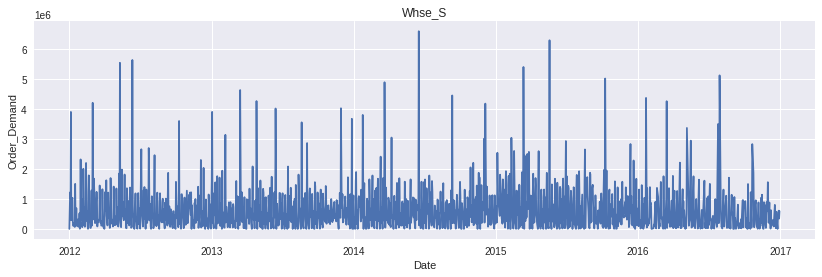

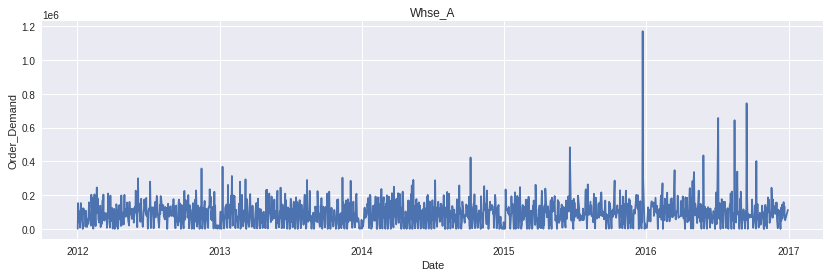

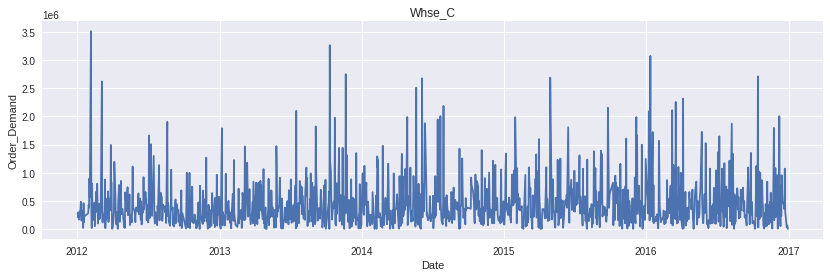

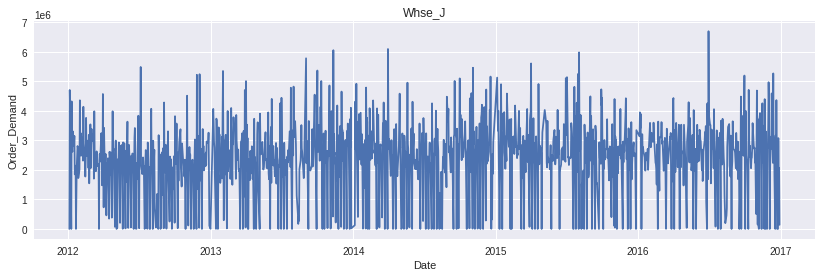

In [35]:
# demand per year per warehouse linear plot
list_dfs_warehouses = list_dfs_warehouses(df)
line_plot_warehouses_data(list_dfs_warehouses, 14, 4)


In [36]:
# order demand per warehouse and date table
df_warehouse_concat = pd.concat(list_dfs_warehouses)
df_warehouse_concat.sort_values(by='Date', inplace=True)
df_warehouse_concat


Date Warehouse  Order_Demand
0    2012-01-01    Whse_S             2
2    2012-01-02    Whse_S        679777
1    2012-01-02    Whse_A           500
3    2012-01-03    Whse_A        152892
4    2012-01-03    Whse_C        275137
...         ...       ...           ...
5807 2016-12-29    Whse_S        346256
5806 2016-12-29    Whse_J        139046
5810 2016-12-30    Whse_S        590180
5809 2016-12-30    Whse_C             0
5808 2016-12-30    Whse_A        112770

[5811 rows x 3 columns]

In [37]:
# demand per warehouse more deep analysis
df_warehouse_info(df_warehouse_concat)


--- DATA FRAME INFO ---

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1681 entries, 2012-01-01 to 2016-12-30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Whse_A  1681 non-null   int64
 1   Whse_C  1681 non-null   int64
 2   Whse_J  1681 non-null   int64
 3   Whse_S  1681 non-null   int64
dtypes: int64(4)
memory usage: 65.7 KB
None

--- ZERO DEMANDS PERCENTAGE ---

Warehouse
Whse_A     8.209399
Whse_C    21.713266
Whse_J    19.393218
Whse_S     7.674004
dtype: float64

--- DATA FRAME PIVOTED BY DATE ---



Warehouse   Whse_A  Whse_C   Whse_J   Whse_S
Date                                        
2012-01-01       0       0        0        2
2012-01-02     500       0        0   679777
2012-01-03  152892  275137        0  1217228
2012-01-04   69163  204000      120  1022578
2012-01-05   38834  298318  4701940  3902682
...            ...     ...      ...      ...
2016-12-26       0  110600  3073044   444726
2016-12-27       0   27000  1215751   431475
2016-12-28       0   62910  2068312   609080
2016-12-29       0   45185   139046   346256
2016-12-30  112770       0        0   590180

[1681 rows x 4 columns]

**OBSERVATION:** warehouse S is the most agitated one because its lowest zero demand percentage. By the other hand, Warehouse C has more days with zero demand from 2012 to 2016.

[>>> Click here to go to index <<<](#index)

<a name='time_series_study'></a>
### Time series study

In [38]:
# demand by date data frame generation
df_demand_by_date = demand_by_date(df)
df_demand_by_date.head()


--- DEMAND PER DAY DATA FRAME INFO ---

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

--- DEMAND PER DAY DATA FRAME ---



Order_Demand
Date                    
2012-01-01             2
2012-01-02        680277
2012-01-03       1645257
2012-01-04       1295861
2012-01-05       8941774

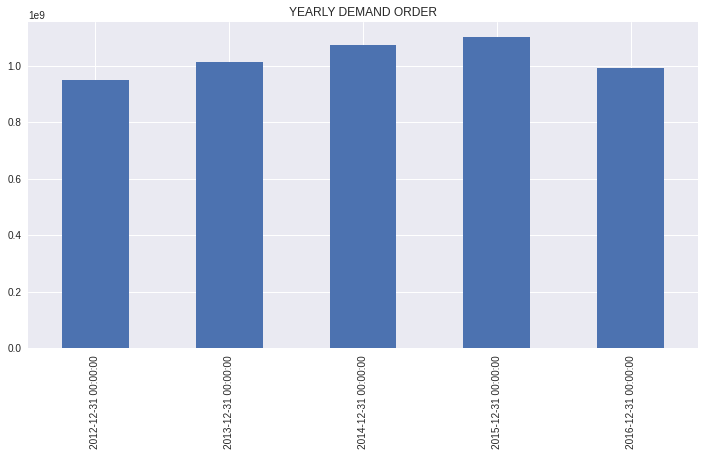

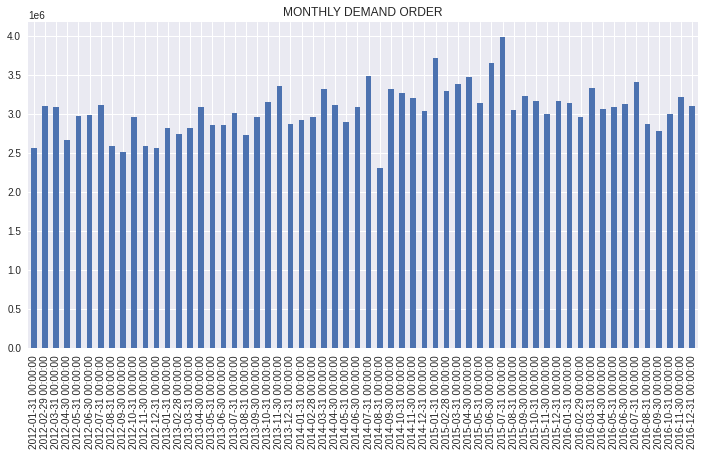

In [39]:
# yearly and monthly demand order
plot_demand_by_year_month(df_demand_by_date)


**OBSERVATION:** the top year in terms of demand from 2012 to 2016 was 2015 and the top month was july 2015. Almost in all years july is the best month and this should be studied in order to bring more business information.

[>>> Click here to go to index <<<](#index)

### Time Series Decomposition

In [40]:
# search for null values on daily, weekly and monthly analysis
periods = ['B', 'W', 'M']
y_periods = y_period(df_demand_by_date, periods)

for idx in range(len(y_periods)):
    if idx == 0:
        y_daily = y_periods[idx]
        print(f'NULL VALUES FOR DAILY TS: {y_daily.isna().sum()}')
    elif idx == 1:
        y_weekly = y_periods[idx]        
        print(f'NULL VALUES FOR WEEKLY TS: {y_weekly.isna().sum()}')
    else:
        y_monthly = y_periods[idx]
        print(f'NULL VALUES FOR MONTHLY TS: {y_monthly.isna().sum()}')
        

NULL VALUES FOR DAILY TS: 0
NULL VALUES FOR WEEKLY TS: 0
NULL VALUES FOR MONTHLY TS: 0


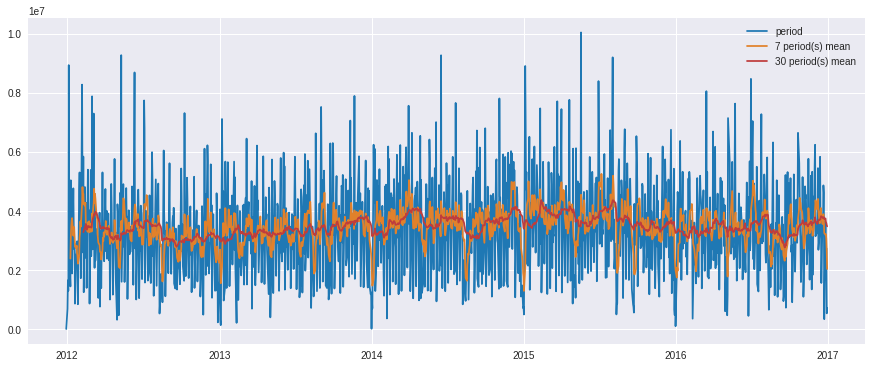

In [41]:
# plot time series on a daily basis, 7 days basis and 30 days basis
df_plot_period_ts(y_daily, 7, 30)


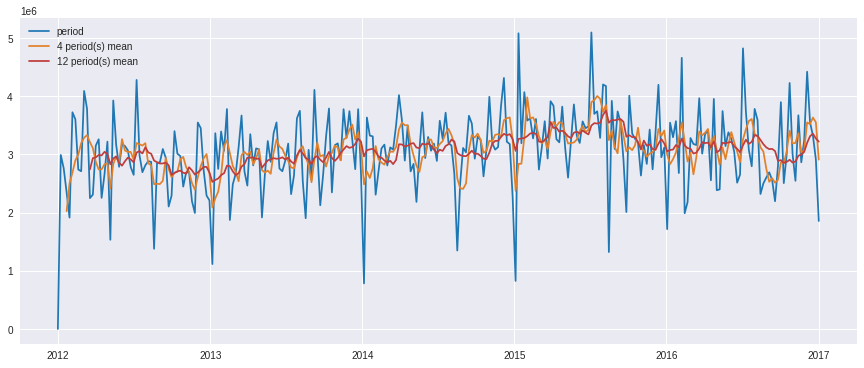

In [42]:
# plot time series on a weekly basis, 4 weeks basis and 12 weeks basis
df_plot_period_ts(y_weekly, 4, 12)


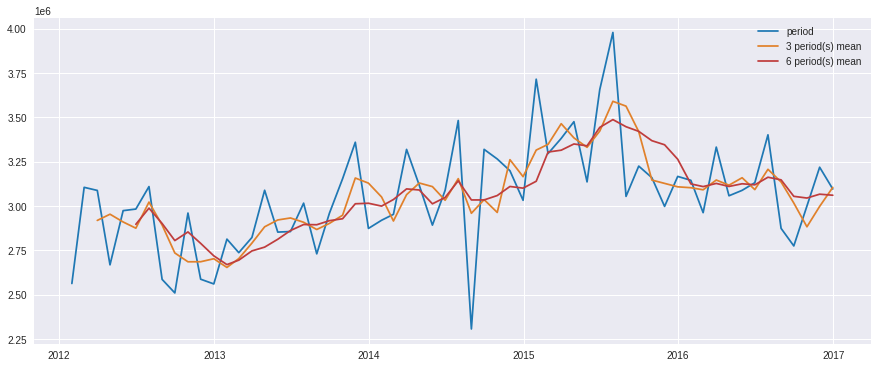

In [43]:
# plot time series on a monthly basis, 3 months basis and 6 months basis
df_plot_period_ts(y_monthly, 3, 6)


**OBSERVATION:** daily and monthly plots show some kind of regularity in demand from 2012 to 2016, but monthly plot show some irregularity at second semester of 2014 and this should be studied.

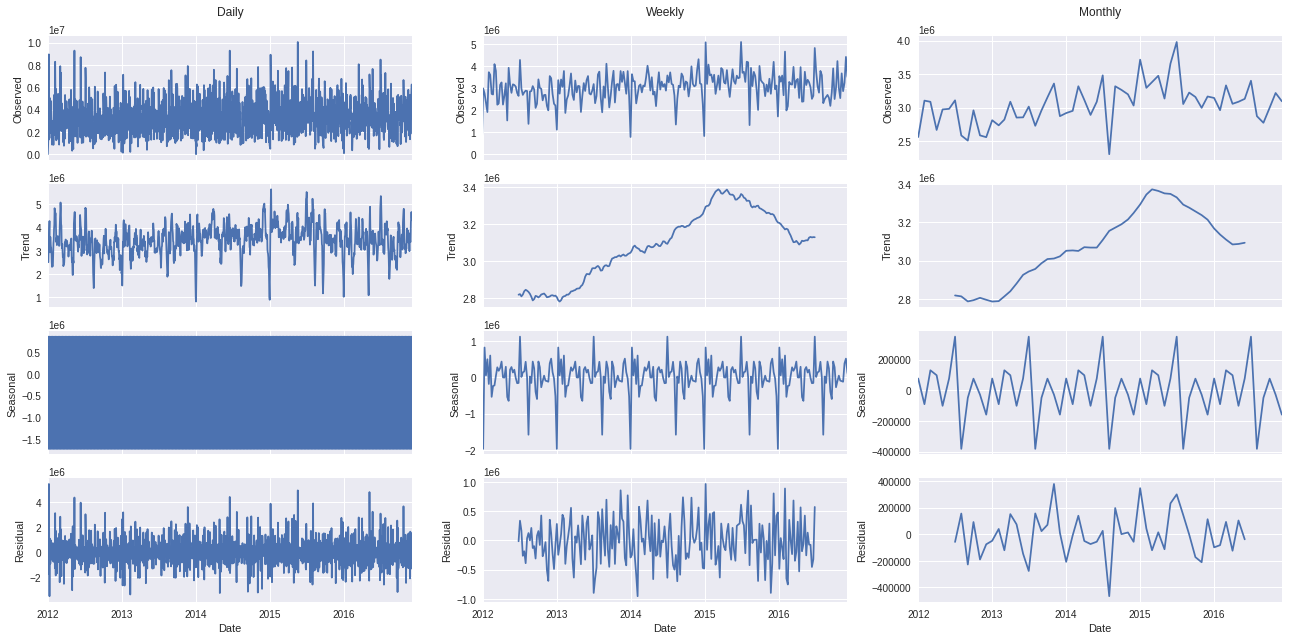

In [44]:
# time series decomposition on a daily, weekly and monthly basis
decomposition_daily = sm.tsa.seasonal_decompose(y_daily, model = 'additive')
decomposition_weekly = sm.tsa.seasonal_decompose(y_weekly, model = 'additive')
decomposition_monthly = sm.tsa.seasonal_decompose(y_monthly, model = 'additive')
plotseasonal_decomposition(decomposition_daily, decomposition_weekly, decomposition_monthly)


**OBSERVATION:** it was assumed an additive model due to the observed plots at time series study. Daily trend has no meaninfull information, but monthly and yearly trends reveals a incresing demand tendency until firs semester of 2015 and then a decrising demand tendency. Seasonality and residual plots information extracted from the series does seem reasonable for the period.

<a name='sma_ewma_daily'></a>
### Simple moving average x Exponential weighted moving average - DAILY

In [45]:
# data frame generation for studies
y_d = pd.DataFrame(y_daily).copy()
y_d['7_daily_SMA'] = SMA_EWMA(y_daily, 7, 30, 3, 6)[0]
y_d['30_daily_SMA'] = SMA_EWMA(y_daily, 7, 30, 3, 6)[1]
y_d['3_span_daily_EWMA'] = SMA_EWMA(y_daily, 7, 30, 3, 6)[2]
y_d['6_span_daily_EWMA'] = SMA_EWMA(y_daily, 7, 30, 3, 6)[3]


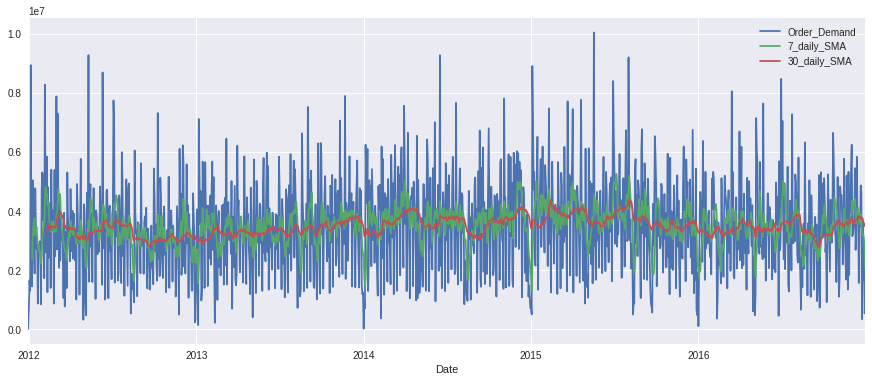

In [46]:
# plot daily order demand, 7 days simple moving average and 30 days simple moving average demand
y_d[['Order_Demand', '7_daily_SMA', '30_daily_SMA']].plot();


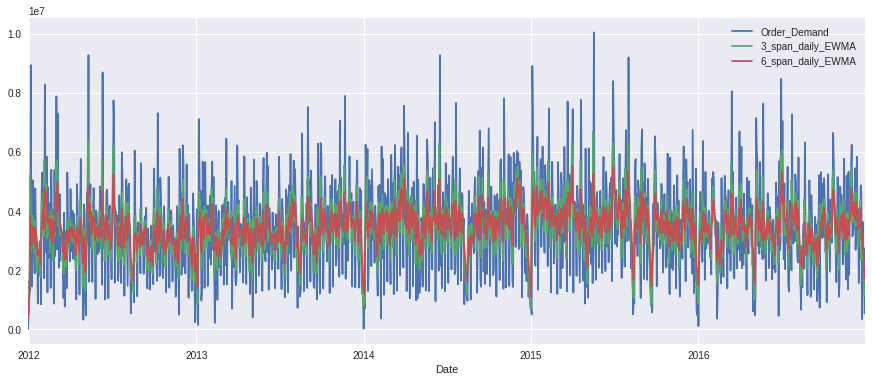

In [47]:
# plot daily order demand, 3 span exponential weighted moving average and 6 span exponential weighted moving average
y_d[['Order_Demand', '3_span_daily_EWMA', '6_span_daily_EWMA']].plot();


In [48]:
# add more columns for more studies
y_d['SIMPExpSmooth_level_06'] = SimpleExpSmoothing(y_d['Order_Demand'], initialization_method='heuristic').fit(smoothing_level=0.6, optimized=False).fittedvalues
y_d['SIMPExpSmooth_estimated'] = SimpleExpSmoothing(y_d['Order_Demand'], initialization_method="estimated").fit().fittedvalues
y_d['ExpSmooth_trendadd'] = ExponentialSmoothing(y_d['Order_Demand'], trend='add').fit().fittedvalues


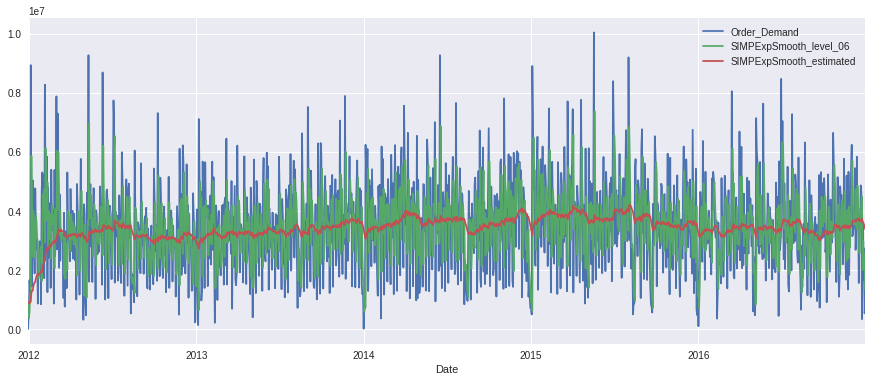

In [49]:
# plot daily order demand, level 6 simple exponential smoothing and estimated simple exponential smoothing
y_d[['Order_Demand', 'SIMPExpSmooth_level_06', 'SIMPExpSmooth_estimated']].plot();


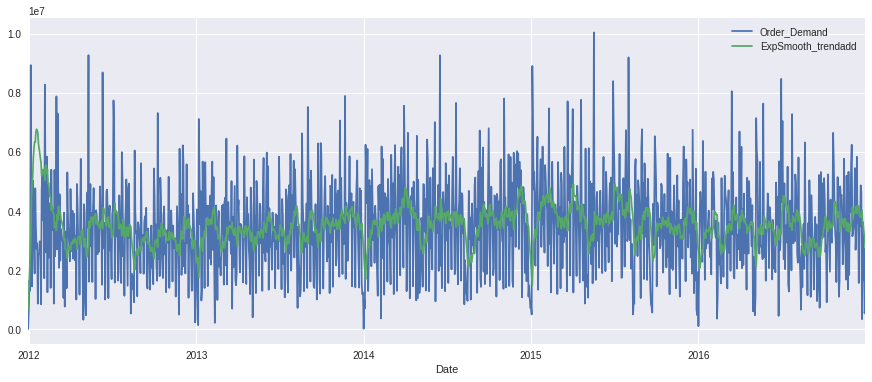

In [50]:
# plot daily demand and exponential smooth trend on additive model
y_d[['Order_Demand', 'ExpSmooth_trendadd']].plot();


[>>> Click here to go to index <<<](#index)

<a name='sma_ewma_weekly'></a>
### Simple moving average x Exponential weighted moving average - WEEKLY
Coments are the same as above for week period

In [51]:
y_w = pd.DataFrame(y_weekly).copy()
y_w['4_week_SMA'] = SMA_EWMA(y_weekly, 4, 12, 3, 6)[0]
y_w['12_week_SMA'] = SMA_EWMA(y_weekly, 4, 12, 3, 6)[1]
y_w['3_span_EWMA'] = SMA_EWMA(y_weekly, 4, 12, 3, 6)[2]
y_w['6_span_EWMA'] = SMA_EWMA(y_weekly, 4, 12, 3, 6)[3]


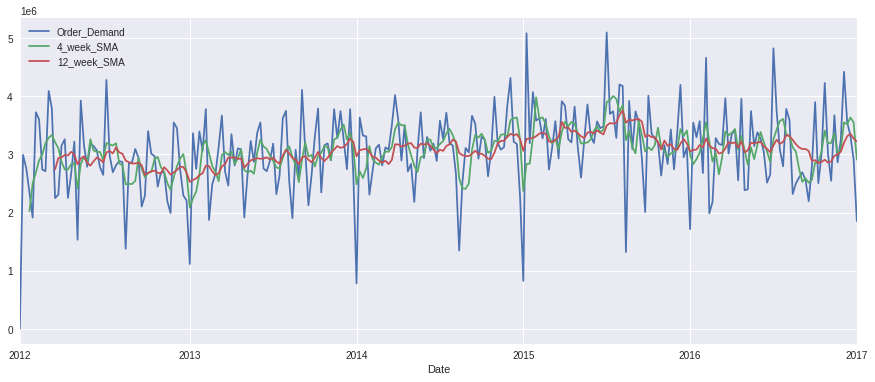

In [52]:
y_w[['Order_Demand', '4_week_SMA', '12_week_SMA']].plot();


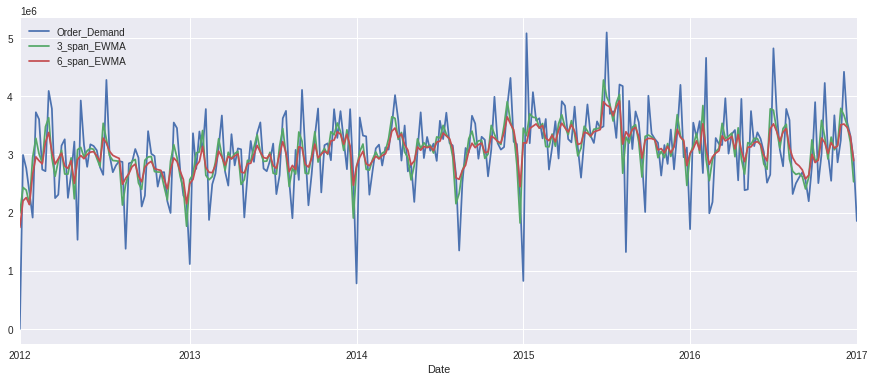

In [53]:
y_w[['Order_Demand', '3_span_EWMA', '6_span_EWMA']].plot();


In [54]:
y_w['SIMPExpSmooth_level_06'] = SimpleExpSmoothing(y_w['Order_Demand'], initialization_method='heuristic').fit(smoothing_level=0.6, optimized=False).fittedvalues
y_w['SIMPExpSmooth_estimated'] = SimpleExpSmoothing(y_w['Order_Demand'], initialization_method="estimated").fit().fittedvalues
y_w['ExpSmooth_trendadd'] = ExponentialSmoothing(y_w['Order_Demand'], trend='add').fit().fittedvalues


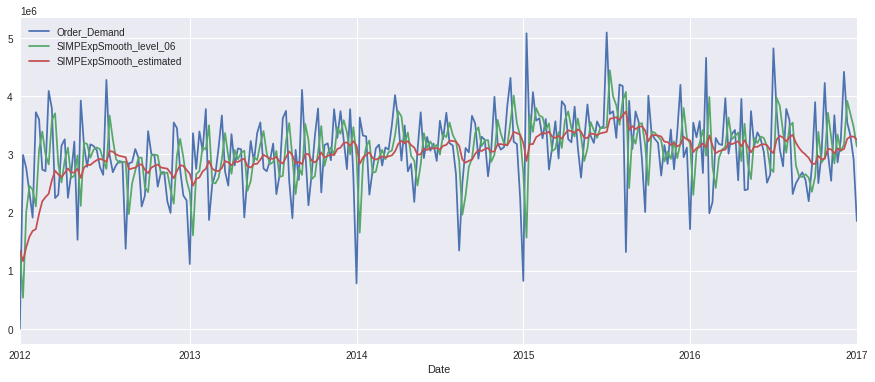

In [55]:
y_w[['Order_Demand', 'SIMPExpSmooth_level_06', 'SIMPExpSmooth_estimated']].plot();


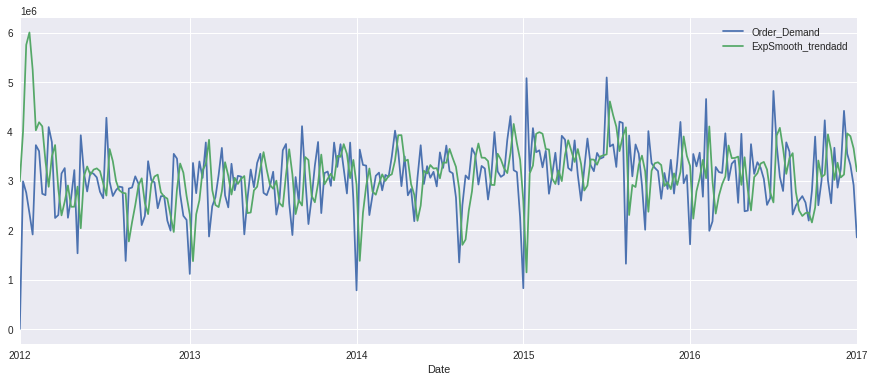

In [56]:
y_w[['Order_Demand', 'ExpSmooth_trendadd']].plot();


<a name='sma_ewma_monthly'></a>
### Simple moving average x Exponential weighted moving average - MONTHLY
Coments are the same as above for week period

In [57]:
y_m = pd.DataFrame(y_monthly).copy()
y_m['3_month_SMA'] = SMA_EWMA(y_monthly, 3, 6, 3, 6)[0]
y_m['6_month_SMA'] = SMA_EWMA(y_monthly, 3, 6, 3, 6)[1]
y_m['3_span_EWMA'] = SMA_EWMA(y_monthly, 3, 6, 3, 6)[2]
y_m['6_span_EWMA'] = SMA_EWMA(y_monthly, 3, 6, 3, 6)[3]


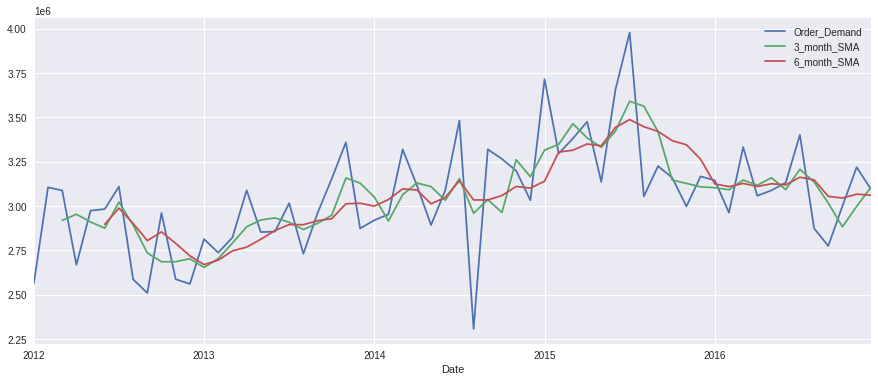

In [58]:
y_m[['Order_Demand', '3_month_SMA', '6_month_SMA']].plot();


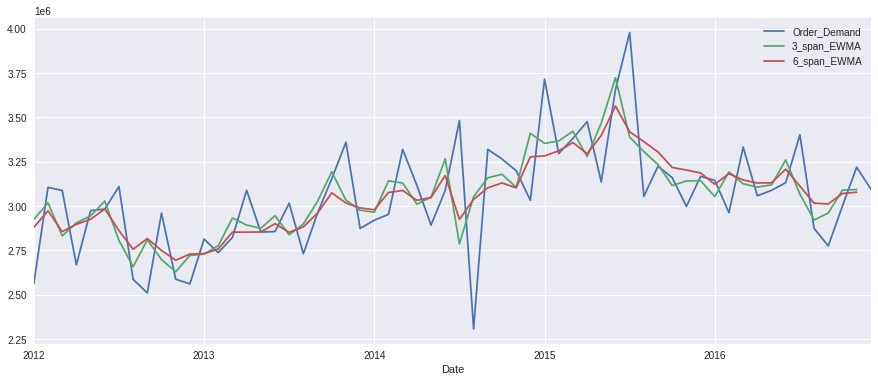

In [59]:
y_m[['Order_Demand', '3_span_EWMA', '6_span_EWMA']].plot();


In [60]:
y_m['SIMPExpSmooth_level_06'] = SimpleExpSmoothing(y_m['Order_Demand'], initialization_method='heuristic').fit(smoothing_level=0.6, optimized=False).fittedvalues
y_m['SIMPExpSmooth_estimated'] = SimpleExpSmoothing(y_m['Order_Demand'], initialization_method="estimated").fit().fittedvalues
y_m['ExpSmooth_trendadd'] = ExponentialSmoothing(y_m['Order_Demand'], trend='add').fit().fittedvalues
y_m['ExpSmooth_trendmul'] = ExponentialSmoothing(y_m['Order_Demand'], trend='mul').fit().fittedvalues
y_m['ExpSmooth_trendmul_seasmul12'] = ExponentialSmoothing(y_m['Order_Demand'], trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues


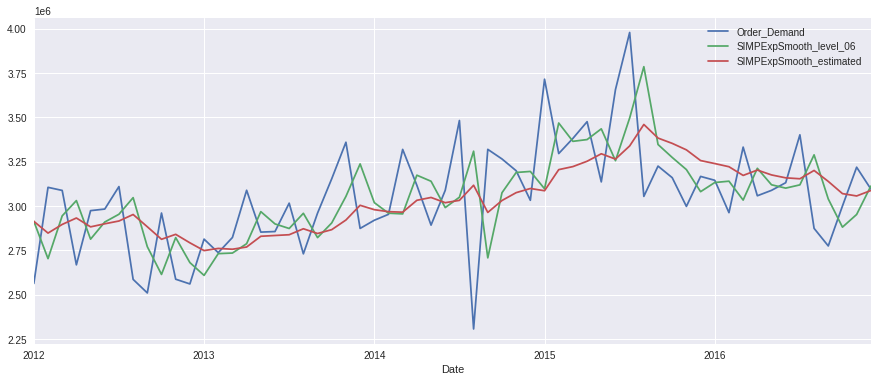

In [61]:
y_m[['Order_Demand', 'SIMPExpSmooth_level_06', 'SIMPExpSmooth_estimated']].plot();


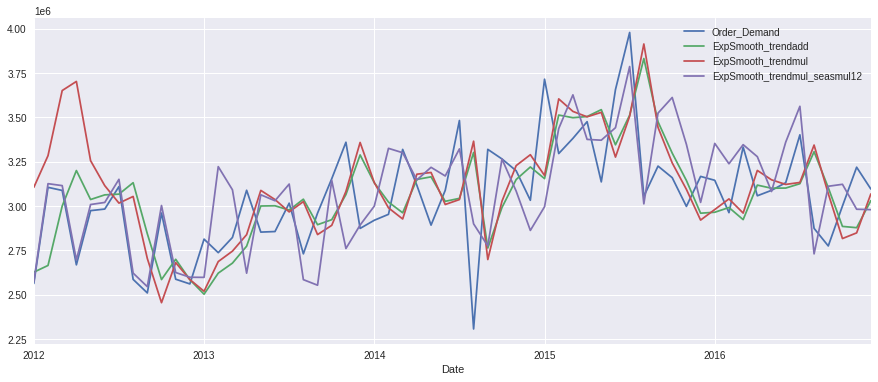

In [62]:
y_m[['Order_Demand', 'ExpSmooth_trendadd', 'ExpSmooth_trendmul', 'ExpSmooth_trendmul_seasmul12']].plot();


[>>> Click here to go to index <<<](#index)

<a name='check_stationarity'></a>
### Check stationarity

The Time series data model works on stationary data. The stationarity of data is described by the following three criteria:-

1) It should have a constant mean

2) It should have a constant variance

3) Auto covariance does not depend on the time

*Mean – it is the average value of all the data

*Variance – it is a difference of each point value from the mean

*Auto covariance –it is a relationship between any two values at a certain amount of time.

**Method to check the stationarity of the Time Series Data:**

There are two methods in python to check data stationarity:

1) Rolling statistics:

This method gave a visual representation of the data to define its stationarity. A Moving variance or moving average graph is plot and then it is observed whether it varies with time or not. In this method, a moving window of time is taken (based on our needs, for eg-10, 12, etc.) and then the mean of that time period is calculated as the current value.

2) Augmented Dickey- fuller Test (ADCF):

In this method, we take a null hypothesis that the data is non-stationary. After executing this test, it will give some results comprised of test statistics and some other critical values that help to define the stationarity. If the test statistic is less than the critical value then we can reject the null hypothesis and say that the series is stationary.

### Check stationarity - DAILY

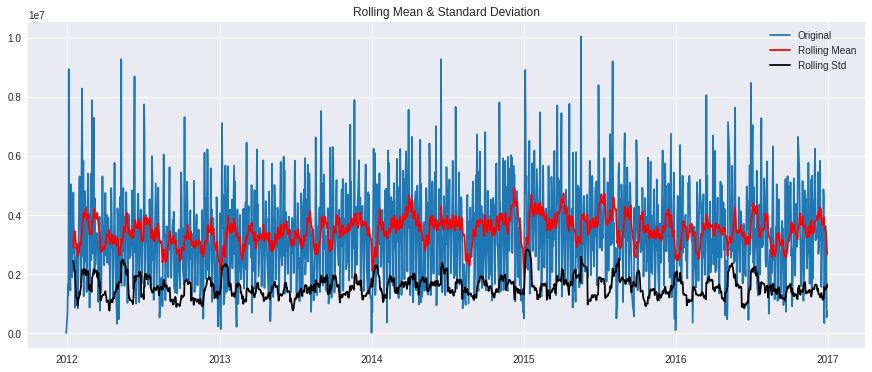

Results of Dickey-Fuller Test:
Test Statistic                -6.732774e+00
p-value                        3.264119e-09
#Lags Used                     1.900000e+01
Number of Observations Used    1.286000e+03
Critical Value (1%)           -3.435445e+00
Critical Value (5%)           -2.863790e+00
Critical Value (10%)          -2.567968e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [63]:
# check daily demand stationarity
test_stationarity(y_daily)


### Check stationarity - WEEKLY

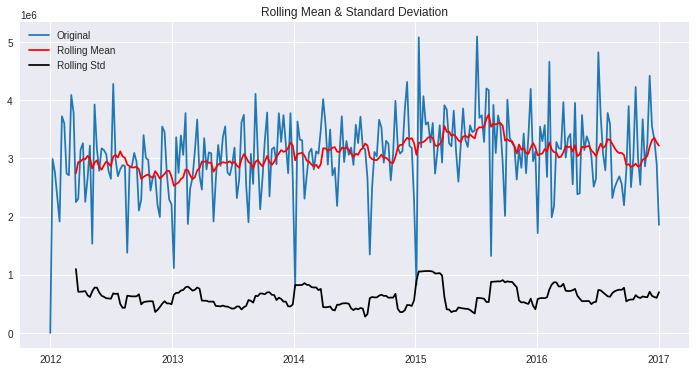

Results of Dickey-Fuller Test:
Test Statistic                -1.571275e+01
p-value                        1.353249e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.610000e+02
Critical Value (1%)           -3.455656e+00
Critical Value (5%)           -2.872678e+00
Critical Value (10%)          -2.572705e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [64]:
# check weekly demand stationarity
test_stationarity(y_weekly)


### Check stationarity - MONTHLY

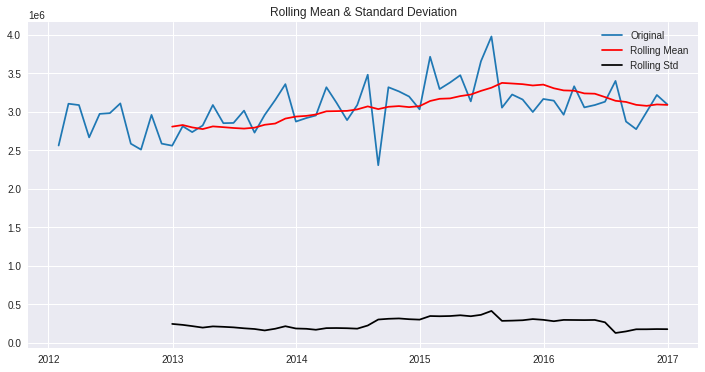

Results of Dickey-Fuller Test:
Test Statistic                 -1.690040
p-value                         0.436251
#Lags Used                      3.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [65]:
# check monthly demand stationarity
test_stationarity(y_monthly)


[>>> Click here to go to index <<<](#index)

<a name='lag_plot'></a>
### Lag plot

A lag plot is a special type of scatter plot with the two variables (X,Y) “lagged.”

A “lag” is a fixed amount of passing time; One set of observations in a time series is plotted (lagged) against a second, later set of data. The kth lag is the time period that happened “k” time points before time i. For example:
Lag1(Y2) = Y1 and Lag4(Y9) = Y5.
The most commonly used lag is 1, called a first-order lag plot.

Plots with a single plotted lag are the most common. However, it is possible to create a lag plot with multiple lags with separate groups (typically different colors) representing each lag.

Lag plots allow you to check for:

1. Model suitability.  
2. Outliers (data points with extremely high or low values).  
3. Randomness (data without a pattern).  
4. Serial correlation (where error terms in a time series transfer from one period to another).  
5. Seasonality (periodic fluctuations in time series data that happens at regular periods).

Source: https://www.statisticshowto.com/lag-plot/

### Lag plot - DAILY

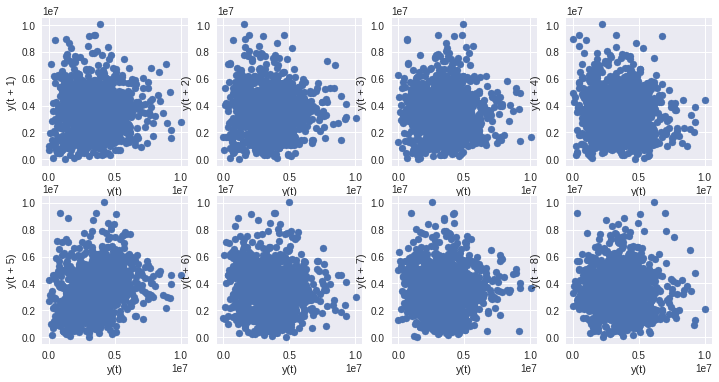

In [66]:
lagplot(y_daily)


**OBSERVATION:** lag plots for a daily period shows no tendency, it confirms the stationarity of the daily demand distribution.

### Lag plot - WEEKLY

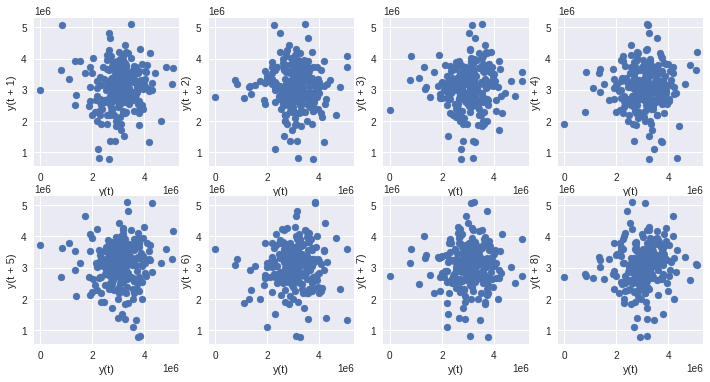

In [67]:
lagplot(y_weekly)


**OBSERVATION:** lag plots for a weekly period shows no tendency, it confirms the stationarity of the weekly demand distribution.

### Lag plot - MONTHLY

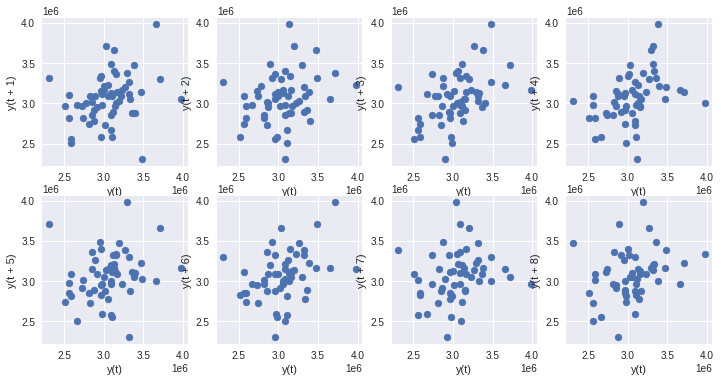

In [68]:
lagplot(y_monthly)


**OBSERVATION:** lag plots for a monthly period tends to show some tendency, it confirms the non-stationarity of the monthly demand distribution.

<a name='autocorr_partialautocorr'></a>
### Autocorrelation and partial autocorrelation plots

The concepts and respective plots of ACF and PACF functions become particularly important when data scientists need to understand and determine the order of autoregressive and moving average time series methods.

ACF is an autocorrelation function that provides you with the information of how much a series is autocorrelated with its lagged values. In simple terms, is describes how well the present value of the series is related with its paste values. 
ACF consider all these components (trend, seasonality and cyclic patterns) while finding correlations

PACF is another important function that, instead of finding correlations of present values with lags like ACF, finds correlation of the residuals with the next lag. It is a function that measures the incremental benefit of adding another lag.

### Autocorrelation and partial autocorrelation plots - DAILY

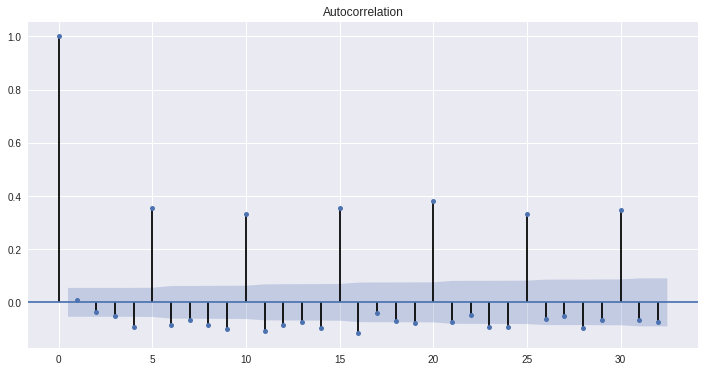

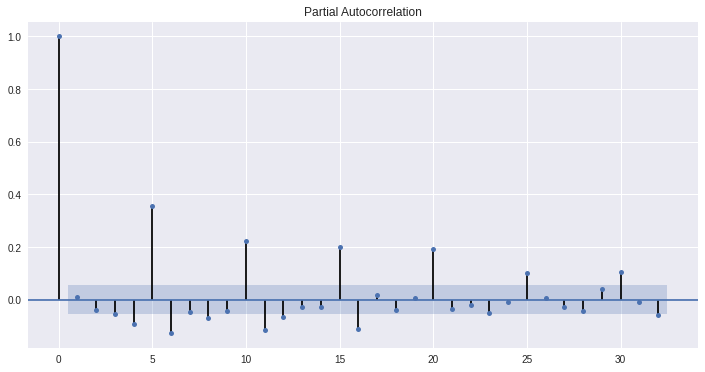

In [69]:
plot_acf(y_daily), plot_pacf(y_daily)
plt.show()


**OBSERVATION:** in this daily basis time series it is possible to see a high autocorrelation about every 5 days and a partial autocorrelation on days 5, 10, 15 and 20.

### Autocorrelation and partial autocorrelation plots - WEEKLY

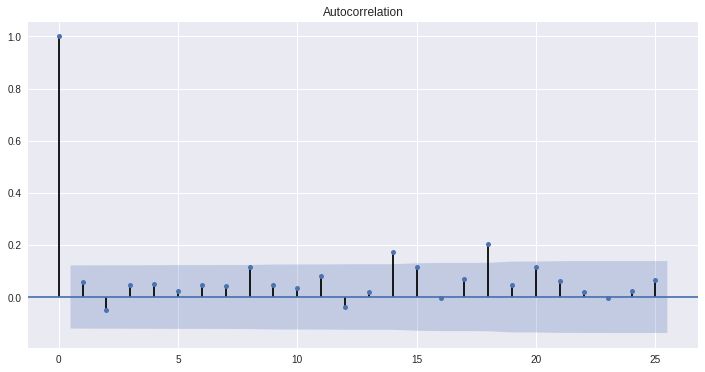

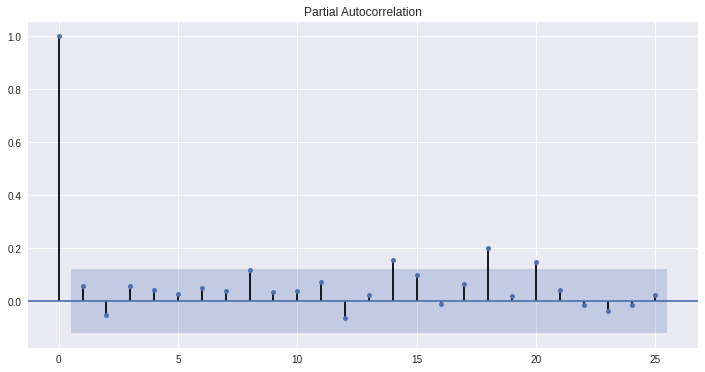

In [70]:
plot_acf(y_weekly), plot_pacf(y_weekly)
plt.show()


**OBSERVATION:** in this weekly basis time series it is possible to see a low autocorrelation at weeks 14 and 18, by the other hand partial autocorrelation is more clear at the weeks 14, 18 and 20.

### Autocorrelation and partial autocorrelation plots - MONTHLY


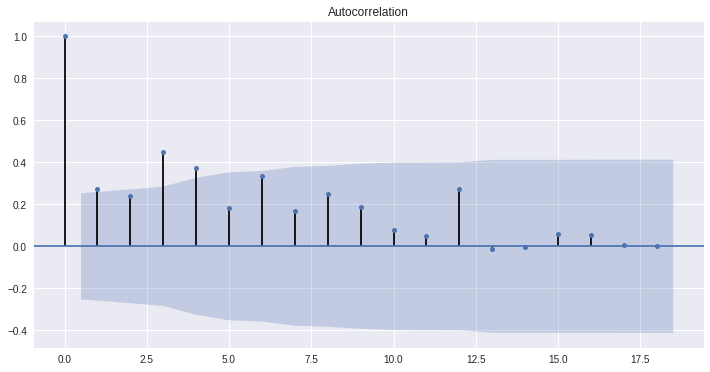

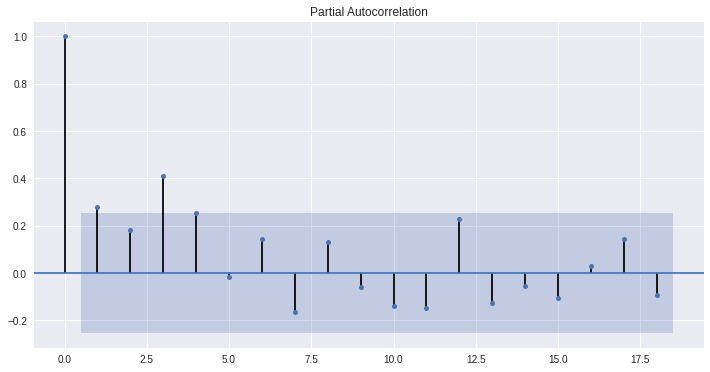

In [71]:
plot_acf(y_monthly), plot_pacf(y_monthly)
plt.show()


**OBSERVATION:** in this monthly basis time series it is possible to see a reasonable autocorrelation at months 3 and 4, by the other hand partial autocorrelation is more clear at month 3.

[>>> Click here to go to index <<<](#index)

<a name='choosen_product'></a>
# Choosen product - dataframe study and preparation

It was decided to choose Product 1359 from Warehouse J. This product is the most important one from the most important category in the most important Warehouse in terms of demand.

In [72]:
# pivoting table
warehouse_category_product = df.groupby(['Warehouse','Product_Category', 'Product_Code']).sum()
warehouse_category_product


Order_Demand     Year
Warehouse Product_Category Product_Code                       
Whse_A    Category_001     Product_1751          1749   255830
          Category_003     Product_1180          9576   467338
                           Product_1719         19359   857798
                           Product_1724         78624  1744150
                           Product_1725          2898   106843
...                                               ...      ...
Whse_S    Category_032     Product_0592          2832   124856
                           Product_0593         43134   259759
                           Product_0595          2748   106724
                           Product_1052         69954   110769
                           Product_1101       1977000   259871

[2849 rows x 2 columns]

In [73]:
# products order demand
warehouses_products_demand = df.groupby('Product_Code')['Order_Demand'].sum().sort_values(ascending=False).to_frame()
warehouses_products_demand


Order_Demand
Product_Code              
Product_1359     472374000
Product_1248     289117000
Product_0083     210651000
Product_1341     166411000
Product_1295     123303000
...                    ...
Product_0638            22
Product_0853            20
Product_0465             3
Product_1703             2
Product_1698             2

[2160 rows x 1 columns]

In [74]:
# choose product 1359 from warehouse J (the top one) for more in depth analysis
chosen_product = df[df['Product_Code']=='Product_1359']
chosen_product = chosen_product.reset_index()
del chosen_product["index"]
chosen_product


Product_Code Warehouse Product_Category       Date  Order_Demand  Year
0      Product_1359    Whse_J     Category_019 2012-01-05         50000  2012
1      Product_1359    Whse_J     Category_019 2012-01-05          5000  2012
2      Product_1359    Whse_J     Category_019 2012-01-05          5000  2012
3      Product_1359    Whse_J     Category_019 2012-01-05          2000  2012
4      Product_1359    Whse_J     Category_019 2012-01-05        300000  2012
...             ...       ...              ...        ...           ...   ...
16930  Product_1359    Whse_J     Category_019 2016-12-28          3000  2016
16931  Product_1359    Whse_J     Category_019 2016-12-28         13000  2016
16932  Product_1359    Whse_J     Category_019 2016-12-28         10000  2016
16933  Product_1359    Whse_J     Category_019 2016-12-28          3000  2016
16934  Product_1359    Whse_J     Category_019 2016-12-28         11000  2016

[16935 rows x 6 columns]

In [75]:
# chosen product table preparation - part one
chosen_product['Year'] = chosen_product['Date'].dt.year
chosen_product['Quarter'] = chosen_product['Date'].dt.quarter
chosen_product['Month'] = chosen_product['Date'].dt.month
chosen_product['Week'] = chosen_product['Date'].dt.week
chosen_product['Day'] = chosen_product['Date'].dt.day
chosen_product


Product_Code Warehouse Product_Category  ... Month  Week  Day
0      Product_1359    Whse_J     Category_019  ...     1     1    5
1      Product_1359    Whse_J     Category_019  ...     1     1    5
2      Product_1359    Whse_J     Category_019  ...     1     1    5
3      Product_1359    Whse_J     Category_019  ...     1     1    5
4      Product_1359    Whse_J     Category_019  ...     1     1    5
...             ...       ...              ...  ...   ...   ...  ...
16930  Product_1359    Whse_J     Category_019  ...    12    52   28
16931  Product_1359    Whse_J     Category_019  ...    12    52   28
16932  Product_1359    Whse_J     Category_019  ...    12    52   28
16933  Product_1359    Whse_J     Category_019  ...    12    52   28
16934  Product_1359    Whse_J     Category_019  ...    12    52   28

[16935 rows x 10 columns]

In [76]:
# chosen product table preparation - part two
chosen_product['Product_Code'] = chosen_product['Product_Code'].apply(lambda x: x.strip('Product_'))
chosen_product['Product_Category'] = chosen_product['Product_Category'].apply(lambda x: x.strip('Category_'))
chosen_product['Product_Code'] = chosen_product['Product_Code'].astype(int)
chosen_product['Product_Category'] = chosen_product['Product_Category'].astype(int)
chosen_product


Product_Code Warehouse  Product_Category  ... Month  Week  Day
0              1359    Whse_J                19  ...     1     1    5
1              1359    Whse_J                19  ...     1     1    5
2              1359    Whse_J                19  ...     1     1    5
3              1359    Whse_J                19  ...     1     1    5
4              1359    Whse_J                19  ...     1     1    5
...             ...       ...               ...  ...   ...   ...  ...
16930          1359    Whse_J                19  ...    12    52   28
16931          1359    Whse_J                19  ...    12    52   28
16932          1359    Whse_J                19  ...    12    52   28
16933          1359    Whse_J                19  ...    12    52   28
16934          1359    Whse_J                19  ...    12    52   28

[16935 rows x 10 columns]

In [77]:
# chosen product table preparation - part three
chosen_product['YearQuarter'] = chosen_product.apply(lambda x: str(x['Year'])+'-'+str(x['Quarter']), axis=1)
chosen_product['YearMonth'] = chosen_product['Date'].apply(lambda x: x.strftime('%Y-%m'))
chosen_product['DayWeek'] = [i.dayofweek for i in chosen_product['Date']]
chosen_product


Product_Code Warehouse  Product_Category  ... YearQuarter  YearMonth  DayWeek
0              1359    Whse_J                19  ...      2012-1    2012-01        3
1              1359    Whse_J                19  ...      2012-1    2012-01        3
2              1359    Whse_J                19  ...      2012-1    2012-01        3
3              1359    Whse_J                19  ...      2012-1    2012-01        3
4              1359    Whse_J                19  ...      2012-1    2012-01        3
...             ...       ...               ...  ...         ...        ...      ...
16930          1359    Whse_J                19  ...      2016-4    2016-12        2
16931          1359    Whse_J                19  ...      2016-4    2016-12        2
16932          1359    Whse_J                19  ...      2016-4    2016-12        2
16933          1359    Whse_J                19  ...      2016-4    2016-12        2
16934          1359    Whse_J                19  ...      2016-4    2016-12        2

[16935 rows x 13 columns]

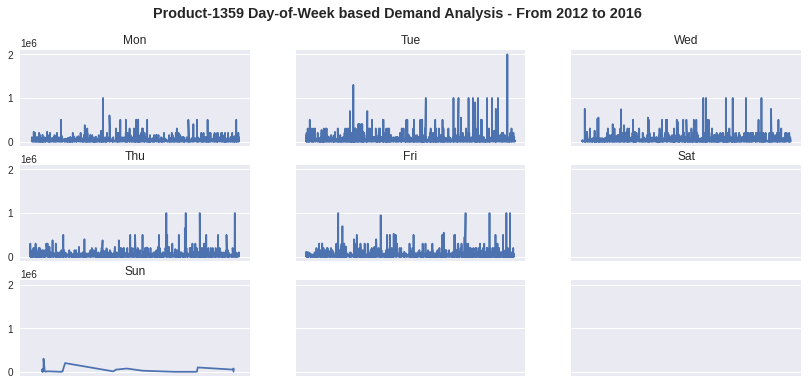

In [78]:
# product 1359 day of week demand from 2012 to 2016
print('\n')
fig, axes = plt.subplots (nrows = 3, ncols = 3, figsize = (14, 6), sharey = True, sharex = True)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for day in range (7):
    chosen_product [chosen_product ['DayWeek'] == day].plot (y = 'Order_Demand', ax = axes [day // 3, day % 3], legend = False, title = days [day])
plt.suptitle ('Product-1359 Day-of-Week based Demand Analysis - From 2012 to 2016', fontweight = 'bold', fontsize = 'x-large')
plt.xticks ([])
plt.show ()


**OBSERVATION:** this product has top demand on tuesdays, minimum demand on sundays and no demand at saturdays at warehouse J.

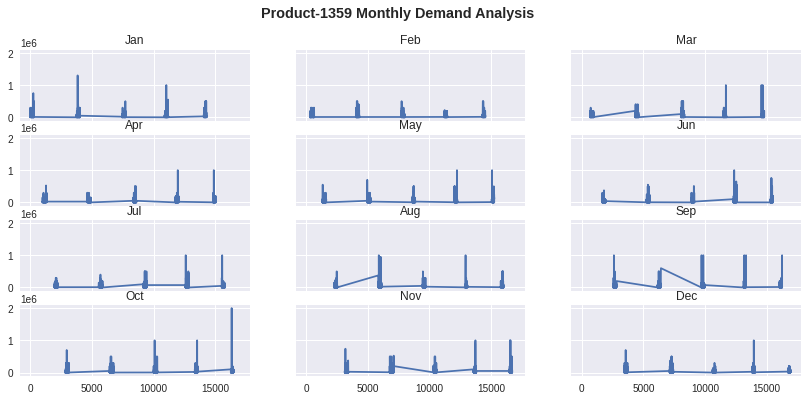

In [79]:
# product 1359 monthly demand from 2012 to 2016
print('\n')
fig, axes = plt.subplots (nrows = 4, ncols = 3, figsize = (14, 6), sharey = True, sharex = True)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month in range (1, 13):
    chosen_product [chosen_product ['Month'] == month]. plot (y = 'Order_Demand', ax = axes [(month - 1) // 3, (month - 1) % 3], legend = False, title = months [month - 1])
plt.suptitle ('Product-1359 Monthly Demand Analysis', fontweight = 'bold', fontsize = 'x-large')
plt.show ()


**OBSERVATION:** this product has top demand on october 2016, and highest demand months seems to be august, september and october at warehouse J.

In [80]:
# temporary data frame for 1359 product demand by date
temp = pd.pivot_table(chosen_product, values='Order_Demand', index=['Date'], columns=['Product_Code'], aggfunc=np.sum).fillna(0)
temp.columns = list(temp.columns)
temp


1359
Date              
2012-01-05  702000
2012-01-06  676000
2012-01-10  783000
2012-01-11  200000
2012-01-12  284000
...            ...
2016-12-21  284000
2016-12-22  180000
2016-12-26  286000
2016-12-27   90000
2016-12-28  140000

[1231 rows x 1 columns]

In [81]:
# temporary data frame for 1359 product demand grouped by date and column label adjusted
features = ['Date', 'Order_Demand']
temp_df = chosen_product.groupby(features).count().reset_index().fillna(0)[features]
temp_df.set_index('Date', inplace = True)
temp_df_grouped = temp_df.groupby(by='index', level='Date').sum()
temp_df_grouped


Order_Demand
Date                    
2012-01-05        659000
2012-01-06        567000
2012-01-10        633000
2012-01-11        113000
2012-01-12        183000
...                  ...
2016-12-21        215000
2016-12-22        165000
2016-12-26        277000
2016-12-27         39000
2016-12-28         87000

[1231 rows x 1 columns]

In [82]:
# temporary data frame for 1359 product demand grouped by date and zero value inserted for days with no demand
temp_df_complete = temp_df_grouped.asfreq('d', fill_value=0)
temp_df_complete['Order_Demand'] = temp_df_complete['Order_Demand'].astype(float)
temp_df_complete.head(10)


Order_Demand
Date                    
2012-01-05      659000.0
2012-01-06      567000.0
2012-01-07           0.0
2012-01-08           0.0
2012-01-09           0.0
2012-01-10      633000.0
2012-01-11      113000.0
2012-01-12      183000.0
2012-01-13      350000.0
2012-01-14           0.0

In [83]:
# check the final date of the analysis period
temp_df_complete.tail(10)


Order_Demand
Date                    
2016-12-19      340000.0
2016-12-20      286000.0
2016-12-21      215000.0
2016-12-22      165000.0
2016-12-23           0.0
2016-12-24           0.0
2016-12-25           0.0
2016-12-26      277000.0
2016-12-27       39000.0
2016-12-28       87000.0

In [84]:
# temporary 1359 product demand per week
temp_week = chosen_product
temp_week['Date'] = pd.to_datetime(chosen_product['Date']) - pd.to_timedelta(0, unit='d')
temp_week = temp_week.groupby(['Product_Code', pd.Grouper(key='Date', freq='W-MON')])['Order_Demand'].sum().reset_index().sort_values('Date')
temp_df_complete_week = temp_week[['Date', 'Order_Demand']].set_index('Date')
temp_df_complete_week.drop(temp_df_complete_week.tail(1).index,inplace=True)
temp_df_complete_week


Order_Demand
Date                    
2012-01-09       1378000
2012-01-16       2278000
2012-01-23       1388000
2012-01-30       2468000
2012-02-06       3090000
...                  ...
2016-11-28       1699000
2016-12-05       1297000
2016-12-12       1502000
2016-12-19       2046000
2016-12-26       1078000

[259 rows x 1 columns]

In [85]:
# temporary 1359 product demand per month
temp_month = chosen_product
temp_month['Date'] = pd.to_datetime(chosen_product['Date']) - pd.to_timedelta(0, unit='m')
temp_month = temp_month.groupby(['Product_Code', pd.Grouper(key='Date', freq='M')])['Order_Demand'].sum().reset_index().sort_values('Date')
temp_df_complete_month = temp_month[['Date', 'Order_Demand']].set_index('Date')
temp_df_complete_month.drop(temp_df_complete_month.tail(1).index,inplace=True)
temp_df_complete_month


Order_Demand
Date                    
2012-01-31       8911000
2012-02-29       8131000
2012-03-31       7775000
2012-04-30       8960000
2012-05-31       8475000
2012-06-30       6556000
2012-07-31       7422000
2012-08-31       6667000
2012-09-30       8349000
2012-10-31       7685000
2012-11-30       7894000
2012-12-31       8302000
2013-01-31       9460000
2013-02-28       8216000
2013-03-31       8025000
2013-04-30       7902000
2013-05-31       8041000
2013-06-30       8324000
2013-07-31       7578000
2013-08-31       8732000
2013-09-30       7590000
2013-10-31       9626000
2013-11-30      10450000
2013-12-31       8748000
2014-01-31       7788000
2014-02-28       7818000
2014-03-31       9189000
2014-04-30       7864000
2014-05-31       8530000
2014-06-30       7055000
2014-07-31       9022000
2014-08-31       5763000
2014-09-30       7838000
2014-10-31       9750000
2014-11-30       8306000
2014-12-31       6198000
2015-01-31      10127000
2015-02-28       5298000
2015-03-31       7533000
2015-04-30       9015000
2015-05-31       7674000
2015-06-30       8521000
2015-07-31       8301000
2015-08-31       6475000
2015-09-30       8325000
2015-10-31       7794000
2015-11-30       7216000
2015-12-31       6803000
2016-01-31       7339000
2016-02-29       7196000
2016-03-31       7556000
2016-04-30       6341000
2016-05-31       6854000
2016-06-30       7870000
2016-07-31       7108000
2016-08-31       6934000
2016-09-30       6960000
2016-10-31       7727000
2016-11-30       8814000

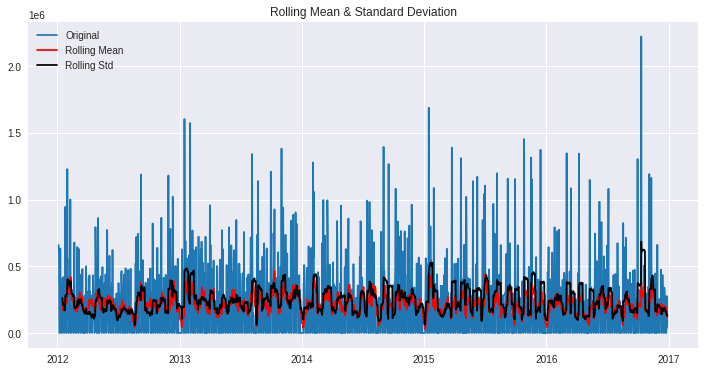

Results of Dickey-Fuller Test:
Test Statistic                -1.072761e+01
p-value                        3.036990e-19
#Lags Used                     2.500000e+01
Number of Observations Used    1.794000e+03
Critical Value (1%)           -3.434000e+00
Critical Value (5%)           -2.863152e+00
Critical Value (10%)          -2.567628e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [86]:
# check stationarity of product 1359 time series on a daily basis
test_stationarity(temp_df_complete)


Text(0.5, 1.0, 'Product 1359 Seazonal Decomposition - Daily Basis Demand')

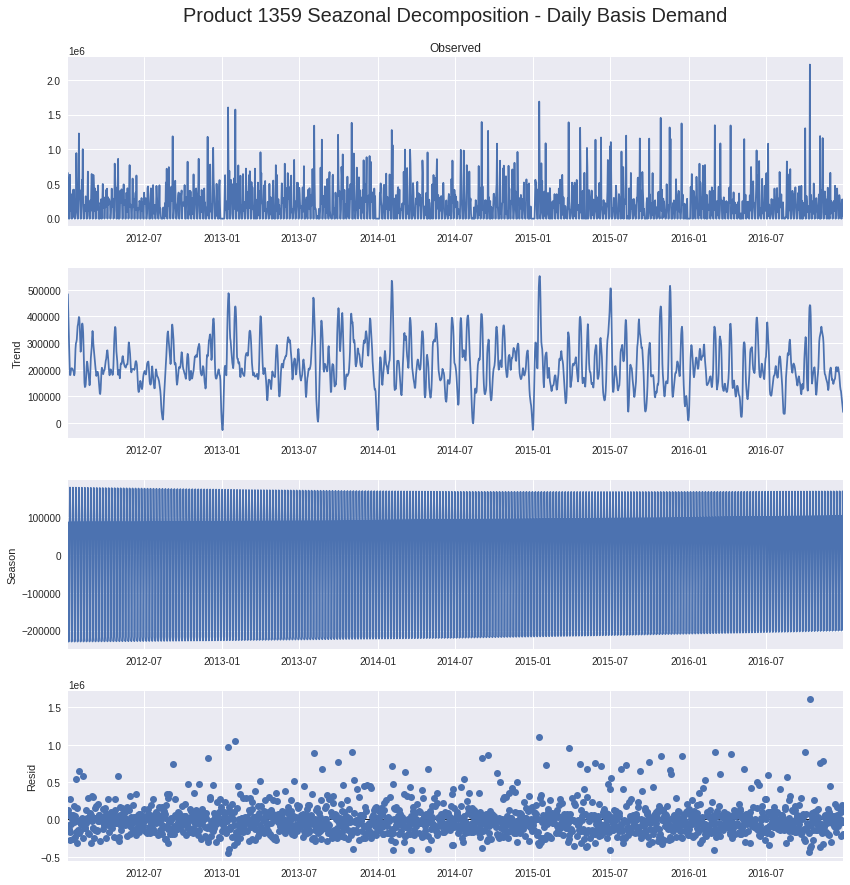

In [87]:
# seazonal decomposition for product 1359
register_matplotlib_converters()
plt.rc("axes.spines", top=False, bottom = False, right=False, left=False)
plt.rc('font', size=13)
plt.rc('figure',figsize=(12,12))
stl = STL(temp_df_complete, seasonal=365)
res = stl.fit()
res.plot()    
plt.title('Product 1359 Seazonal Decomposition - Daily Basis Demand', fontsize = 20, pad=670)


**OBSERVATION:** there is no reasonable information at this decomposition series that may impact future predictions.

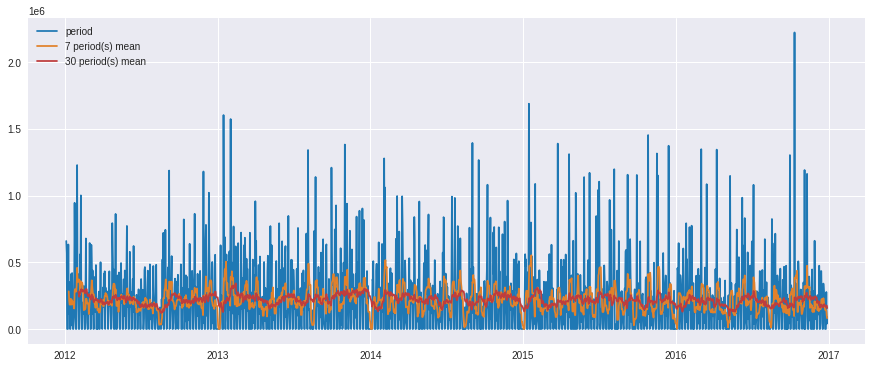

In [88]:
df_plot_period_ts(temp_df_complete, 7, 30)


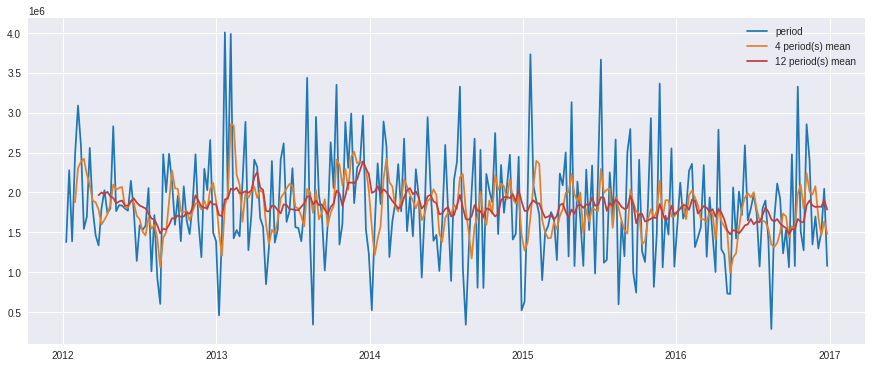

In [89]:
df_plot_period_ts(temp_df_complete_week, 4, 12)


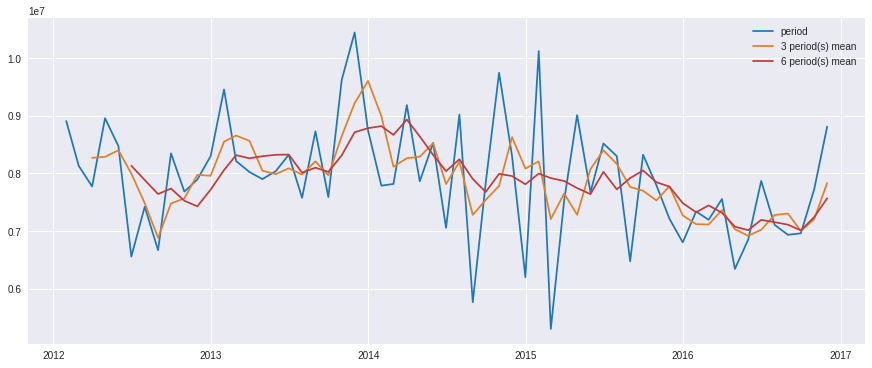

In [90]:
df_plot_period_ts(temp_df_complete_month, 3, 6)


**OBSERVATION:** daily basis will be focused from here. This decision was made because it is easily possible to adjust time for other periods starting by days.

[>>> Click here to go to index <<<](#index)

<a name='forecasting_studies'></a>
### Splitting product 1359 (warehouse J) time series for forecasting studies

In [91]:
# produce train and test data frames
train_temp_df_complete = temp_df_complete.loc[:'2015-12-31']
test_temp_df_complete = temp_df_complete.loc['2016-01-01':]


In [92]:
# shows the end of training data
train_temp_df_complete.tail()


Order_Demand
Date                    
2015-12-27           0.0
2015-12-28      286000.0
2015-12-29           0.0
2015-12-30           0.0
2015-12-31           0.0

In [93]:
# shows the beginning of testing data
test_temp_df_complete.head()


Order_Demand
Date                    
2016-01-01           0.0
2016-01-02           0.0
2016-01-03           0.0
2016-01-04           0.0
2016-01-05      455000.0

In [94]:
print('Training data shape: ', train_temp_df_complete.shape)
print('Test data shape: ', test_temp_df_complete.shape)


Training data shape:  (1457, 1)
Test data shape:  (363, 1)


[>>> Click here to go to index <<<](#index)

<a name='forecasting_benchmarking'></a>
### Forecasting - naïve (benchmarking)

In [95]:
# create lagged dataset
values = pd.DataFrame(temp_df_complete)
dataframe = pd.concat([values.shift(365), values], axis=1)
dataframe.columns = ['Naive Forecast Actual-365', 'Actual']
print(dataframe.head(5))
print(dataframe.tail(5))


            Naive Forecast Actual-365    Actual
Date                                           
2012-01-05                        NaN  659000.0
2012-01-06                        NaN  567000.0
2012-01-07                        NaN       0.0
2012-01-08                        NaN       0.0
2012-01-09                        NaN       0.0
            Naive Forecast Actual-365    Actual
Date                                           
2016-12-24                    68000.0       0.0
2016-12-25                        0.0       0.0
2016-12-26                        0.0  277000.0
2016-12-27                   286000.0   39000.0
2016-12-28                        0.0   87000.0


In [96]:
# naive t-365 data modeling
naive_df_until_2015 = dataframe['Actual'].loc[:'2016-01-01']
naive_df_from_2016 = dataframe['Actual'].loc['2016-01-01':]
naive_prediction_t_365 = dataframe['Naive Forecast Actual-365'].loc['2016-01-01':]


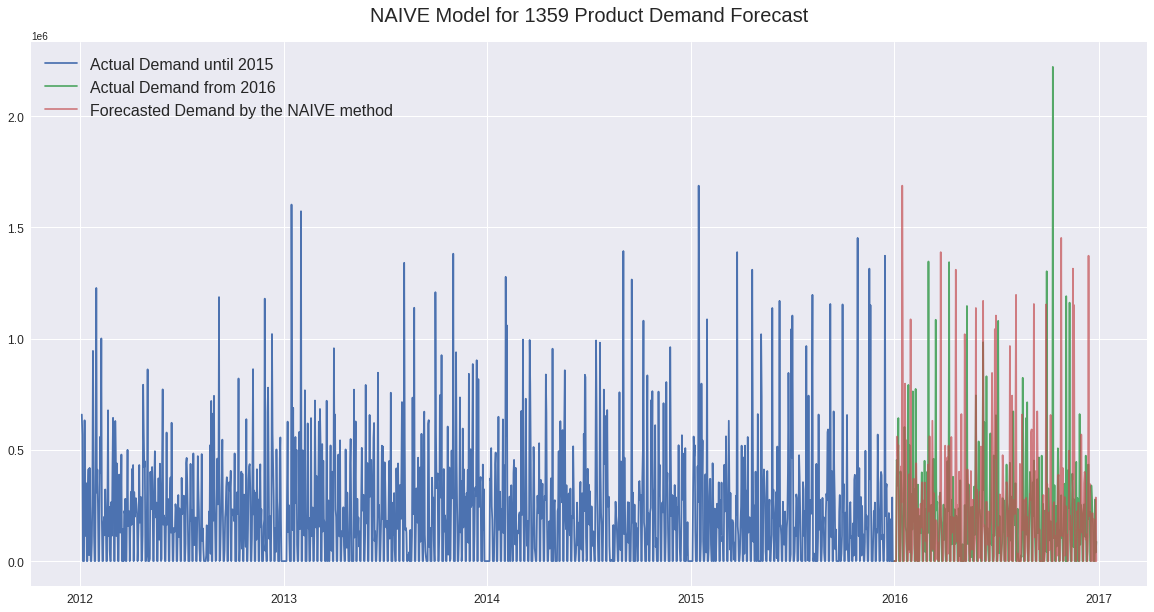

In [97]:
# plot naive prediction all data
plt.figure(figsize=(20, 10))
plt.title("NAIVE Model for 1359 Product Demand Forecast", fontsize=20, pad=21)
plt.plot(naive_df_until_2015, label='Actual Demand until 2015')
plt.plot(naive_df_from_2016, label='Actual Demand from 2016')
plt.plot(naive_prediction_t_365, label='Forecasted Demand by the NAIVE method', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('font', **{'size':'22'})
plt.legend(loc="best", prop={'size': 16});


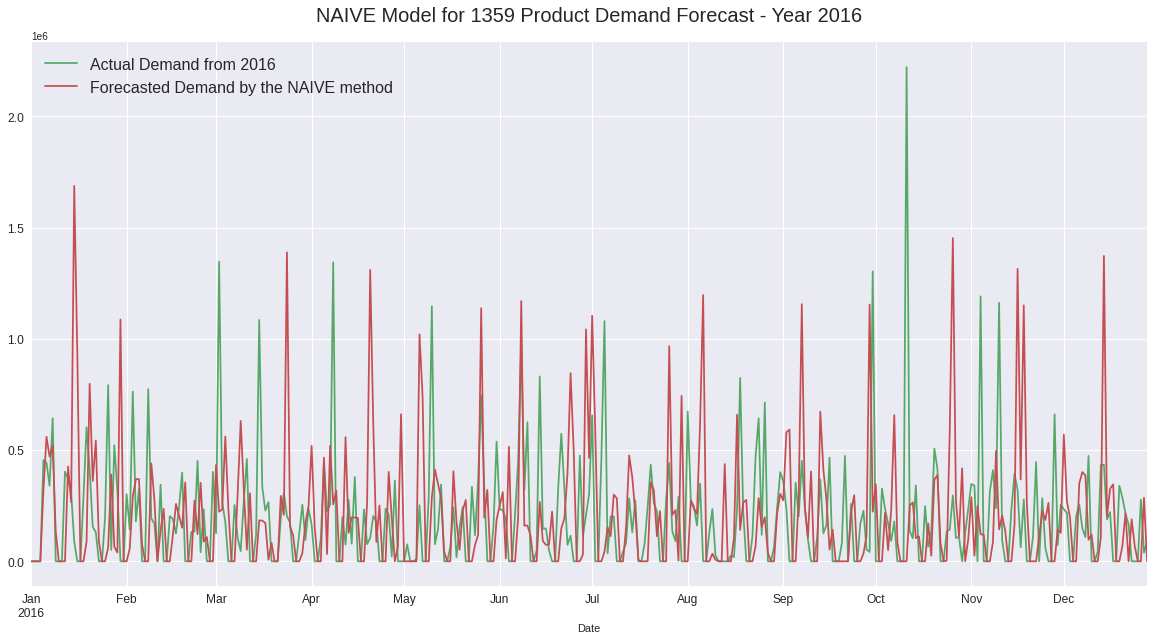

In [98]:
# plot auto naive t-365 prediction year 2016
plt.title("NAIVE Model for 1359 Product Demand Forecast - Year 2016", fontsize=20, pad=21)
naive_df_from_2016.plot(figsize=(20,10), color='#56a868', label='Actual Demand from 2016', legend=True);
naive_prediction_t_365.plot(label='Forecasted Demand by the NAIVE method', color='#c54e52', legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('font', **{'size':'22'})
plt.legend(loc="best", prop={'size': 16});


In [99]:
# prepare data to print related metrics
y_true_naive = naive_df_from_2016.to_numpy()
y_pred_naive = naive_prediction_t_365.to_numpy()
obj0 = Metrics(y_true_naive, y_pred_naive)


In [100]:
print(f'naive mase: {obj0.mean_absolute_scaled_error(clean=True, decimal=5)}')
print(f'naive rmse: {obj0.root_mean_squared_error(clean=True, decimal=5)}')
print(f'naive mae : {obj0.mean_absolute_error(clean=True, decimal=5)}')


naive mase: 1.01409
naive rmse: 405853.3407
naive mae : 284522.63374


[>>> Click here to go to index <<<](#index)

<a name='forecasting_arima'></a>
### Forecasting - ARIMA

In [101]:
# test statistics
y = train_temp_df_complete['Order_Demand']
result = adfuller(y)
result
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -9.872890166562842
p-value: 3.951684360896091e-17


In [102]:
# find best pdq by minimum aic
order_aic(train_temp_df_complete, [10, 2, 5])


order           AIC
5   p3 d1 q4  40168.550087
11  p8 d0 q4  40175.416627
9   p6 d0 q4  40177.436157
8   p5 d1 q4  40177.598486
3   p2 d0 q4  40182.768879
6   p4 d1 q4  40184.931027
4   p3 d0 q4  40186.354567
7   p5 d0 q4  40204.551390
12  p9 d1 q4  40248.746448
10  p6 d1 q4  40276.065950
2   p1 d0 q4  40441.553209
1   p0 d1 q4  40442.679427
0   p0 d0 q4  40443.082902

In [103]:
# creates the model
order = (3, 1, 4)
arima_product_1359 = ARIMA(train_temp_df_complete, order, freq='D')
fit_product_1359 = arima_product_1359.fit(alpha=0.05)

print(fit_product_1359.summary())


                             ARIMA Model Results                              
Dep. Variable:         D.Order_Demand   No. Observations:                 1456
Model:                 ARIMA(3, 1, 4)   Log Likelihood              -20075.275
Method:                       css-mle   S.D. of innovations         234584.602
Date:                Fri, 13 Aug 2021   AIC                          40168.550
Time:                        19:13:59   BIC                          40216.101
Sample:                    01-06-2012   HQIC                         40186.291
                         - 12-31-2015                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -77.7576        nan        nan        nan         nan         nan
ar.L1.D.Order_Demand     0.3635      0.069      5.238      0.000       0.227       0.499
ar.L2.D.Orde

In [104]:
# predictions for year 2016 using arima model
preds_product_1359 = fit_product_1359.predict('2016-01-01', '2016-12-28', typ='levels')
preds_product_1359


2016-01-01    156853.672575
2016-01-02     46962.949996
2016-01-03     37794.963424
2016-01-04    156659.316494
2016-01-05    295835.835848
                  ...      
2016-12-24     26890.828968
2016-12-25     24968.368505
2016-12-26    130213.325600
2016-12-27    263283.408011
2016-12-28    323922.161318
Freq: D, Length: 363, dtype: float64

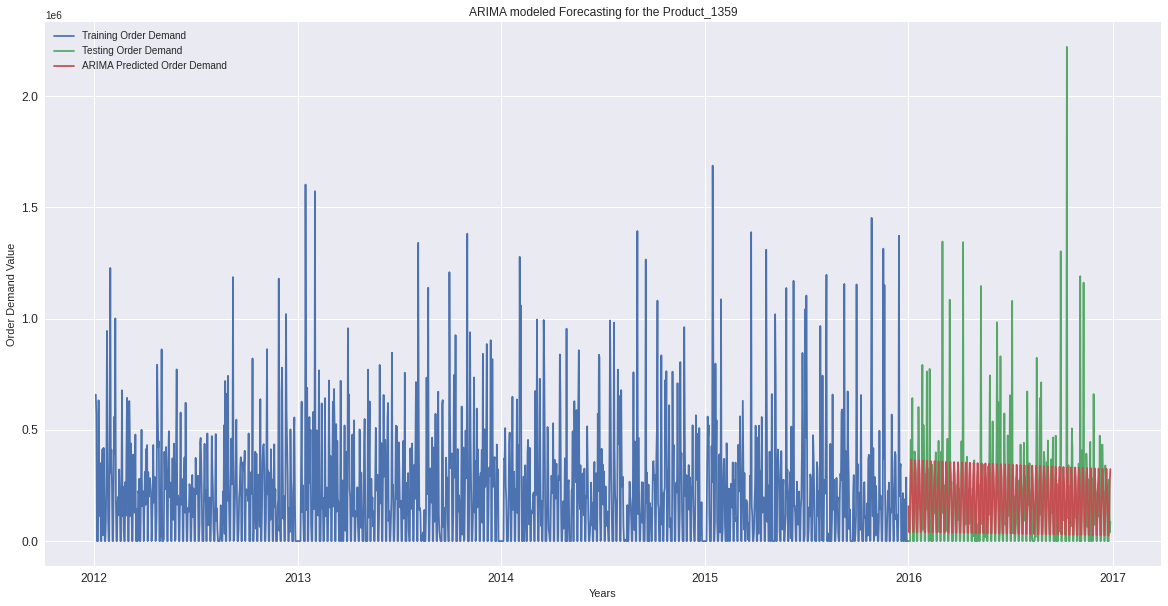

In [105]:
# plot arima prediction all data (train, test and prediction)
plt.figure(figsize=(20, 10))
plt.title("ARIMA modeled Forecasting for the Product_1359")
plt.plot(train_temp_df_complete, label='Training Order Demand')
plt.plot(test_temp_df_complete, label='Testing Order Demand')
plt.plot(preds_product_1359, label='ARIMA Predicted Order Demand')
plt.ylabel('Order Demand Value')
plt.xlabel('Years')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('font', **{'size':'22'})
plt.legend(loc="best", prop={'size': 16});
plt.legend(loc="best");


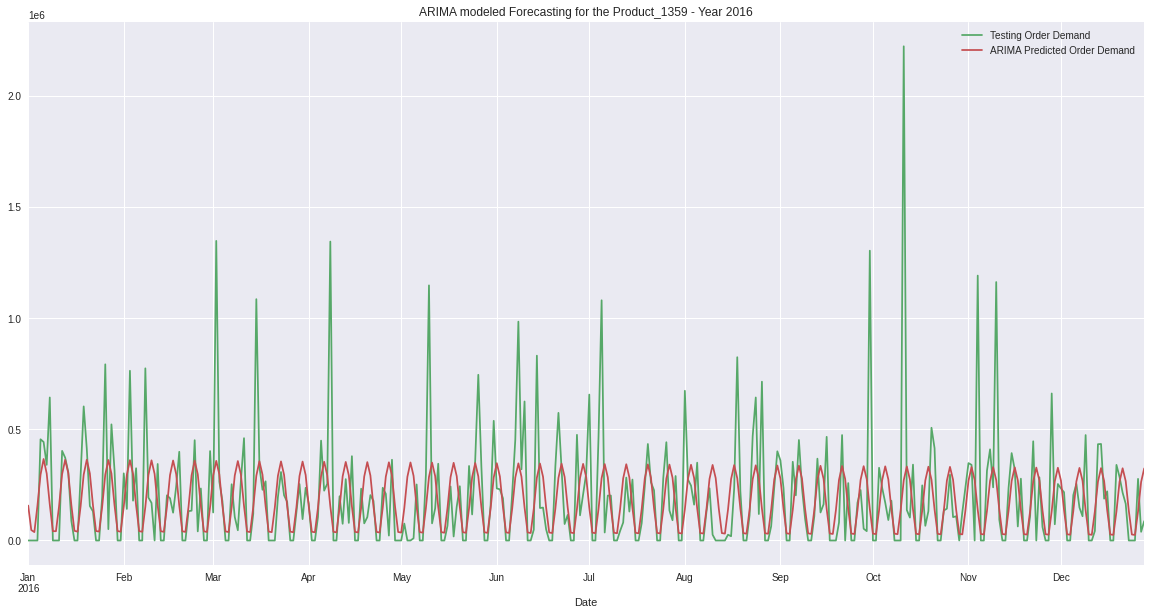

In [106]:
# plot arima prediction test and prediction data
plt.title("ARIMA modeled Forecasting for the Product_1359 - Year 2016")
test_temp_df_complete['Order_Demand'].plot(figsize=(20,10), color='#56a868', label='Testing Order Demand', legend=True);
preds_product_1359.plot(label='ARIMA Predicted Order Demand', color='#c54e52', legend=True);


In [107]:
# prepare data to print related metrics
y_true = test_temp_df_complete['Order_Demand'].to_numpy()
y_pred = preds_product_1359.to_numpy()
obj1 = Metrics(y_true, y_pred)


In [108]:
print(f'arima mase: {obj1.mean_absolute_scaled_error(clean=True, decimal=5)}')
print(f'arima rmse: {obj1.root_mean_squared_error(clean=True, decimal=5)}')
print(f'arima mae : {obj1.mean_absolute_error(clean=True, decimal=5)}')


arima mase: 0.61837
arima rmse: 241853.30245
arima mae : 142107.19061


[>>> Click here to go to index <<<](#index)

<a name='forecasting_auto_arima'></a>
### Forecasting - Auto ARIMA

In [109]:
# creates auto arima model summary
model = pm.auto_arima(temp_df_complete, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # no Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51557.447, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=51080.779, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=51214.433, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=51044.555, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=51000.448, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.86 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.41 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=50550.226, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=50565.101, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=50549.822, Time=0.63 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=50570.680, Time=0.99 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=50540.885, Time=1.72 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=50579.506, Time=0.78 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   :

In [110]:
# creates the auto arima model predictor
auto_arima_order = (3,0,2)
auto_arima_product_1359 = ARIMA(train_temp_df_complete, order = auto_arima_order, freq='D')
auto_arima_fit_product_1359 = auto_arima_product_1359.fit()

print(auto_arima_fit_product_1359.summary())


                              ARMA Model Results                              
Dep. Variable:           Order_Demand   No. Observations:                 1457
Model:                     ARMA(3, 2)   Log Likelihood              -20087.799
Method:                       css-mle   S.D. of innovations         234480.402
Date:                Fri, 13 Aug 2021   AIC                          40189.598
Time:                        19:14:24   BIC                          40226.587
Sample:                    01-05-2012   HQIC                         40203.398
                         - 12-31-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                2.22e+05   6321.505     35.125      0.000     2.1e+05    2.34e+05
ar.L1.Order_Demand     1.2729      0.000   5644.280      0.000       1.272       1.273
ar.L2.Order_Demand  

In [111]:
# predictions for year 2016 using auto arima model
auto_arima_preds_product_1359 = auto_arima_fit_product_1359.predict('2016-01-01', '2016-12-28', typ='levels')
auto_arima_preds_product_1359


2016-01-01    168775.830167
2016-01-02     62117.076580
2016-01-03     67718.256103
2016-01-04    189314.636174
2016-01-05    335549.256385
                  ...      
2016-12-24     63350.780175
2016-12-25     67820.703430
2016-12-26    188420.069939
2016-12-27    334336.763928
2016-12-28    395696.970831
Freq: D, Length: 363, dtype: float64

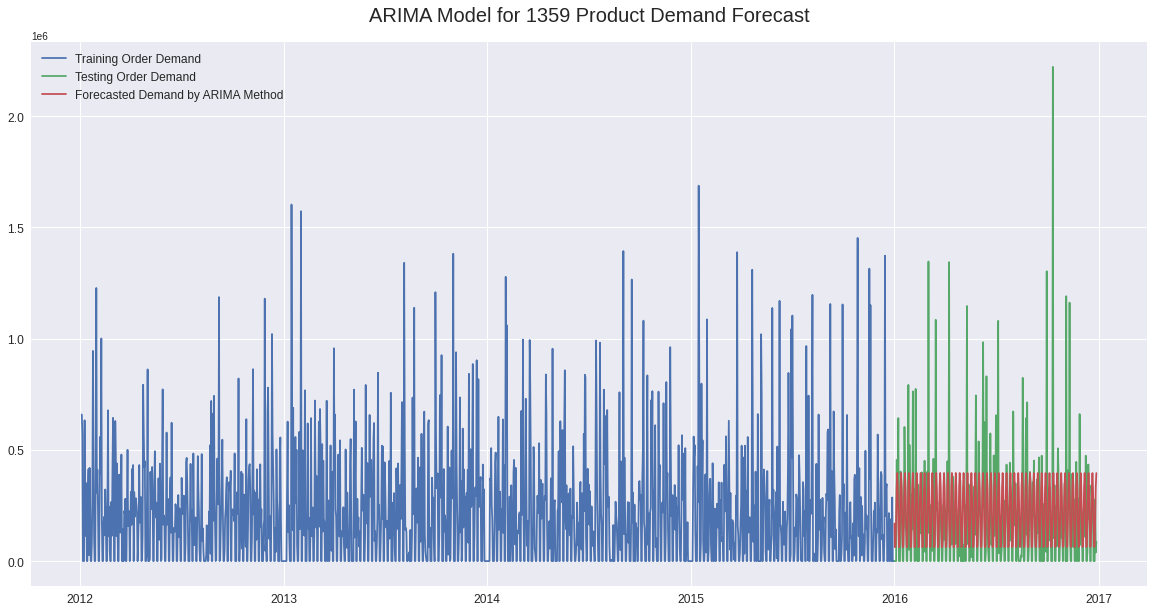

In [112]:
# plot auto arima prediction all data
plt.figure(figsize=(20, 10))
plt.title("ARIMA Model for 1359 Product Demand Forecast", fontsize=20, pad=21)
plt.plot(train_temp_df_complete, label='Training Order Demand')
plt.plot(test_temp_df_complete, label='Testing Order Demand')
plt.plot(auto_arima_preds_product_1359, label='Forecasted Demand by ARIMA Method')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('font', **{'size':'22'})
plt.legend(loc="best", prop={'size': 12});


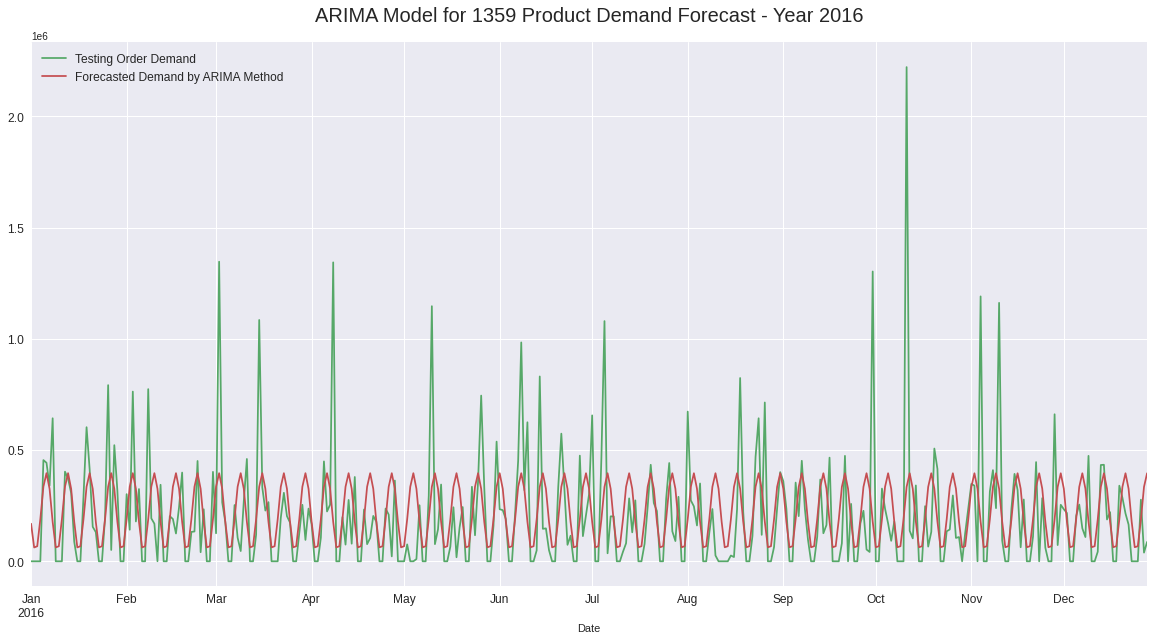

In [113]:
# plot auto arima prediction year 2016
plt.title("ARIMA Model for 1359 Product Demand Forecast - Year 2016", fontsize=20, pad=21)
test_temp_df_complete['Order_Demand'].plot(figsize=(20,10), color='#56a868', label='Testing Order Demand', legend=True)
auto_arima_preds_product_1359.plot(label='Forecasted Demand by ARIMA Method', color='#c54e52', legend=True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('font', **{'size':'22'})
plt.legend(loc="best", prop={'size': 12});


In [114]:
# prepare data to print related metrics
y_true_auto_arima = test_temp_df_complete['Order_Demand'].to_numpy()
y_pred_auto_arima = auto_arima_preds_product_1359.to_numpy()
obj2 = Metrics(y_true_auto_arima, y_pred_auto_arima)


In [115]:
print(f'auto arima mase: {obj2.mean_absolute_scaled_error(clean=True, decimal=5)}')
print(f'auto arima rmse: {obj2.root_mean_squared_error(clean=True, decimal=5)}')
print(f'auto arima mae : {obj2.mean_absolute_error(clean=True, decimal=5)}')


auto arima mase: 0.68261
auto arima rmse: 242612.48257
auto arima mae : 156869.74047


[>>> Click here to go to index <<<](#index)

<a name='forecasting_sma'></a>
### Smoothing moving average - 3 days window prediction for one year

In [116]:
values = pd.DataFrame(temp_df_complete)

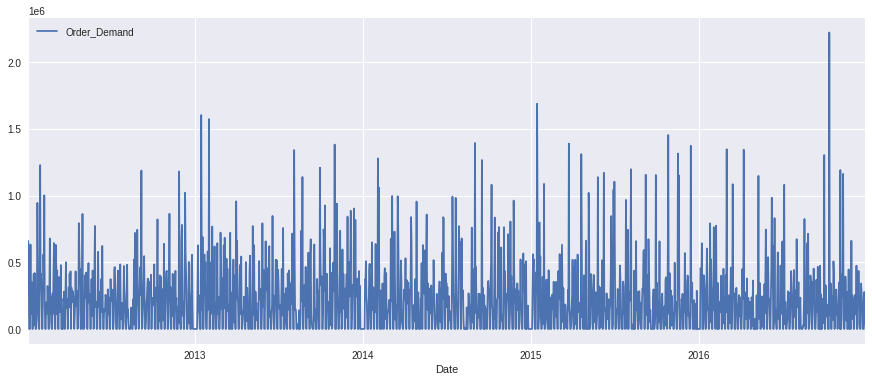

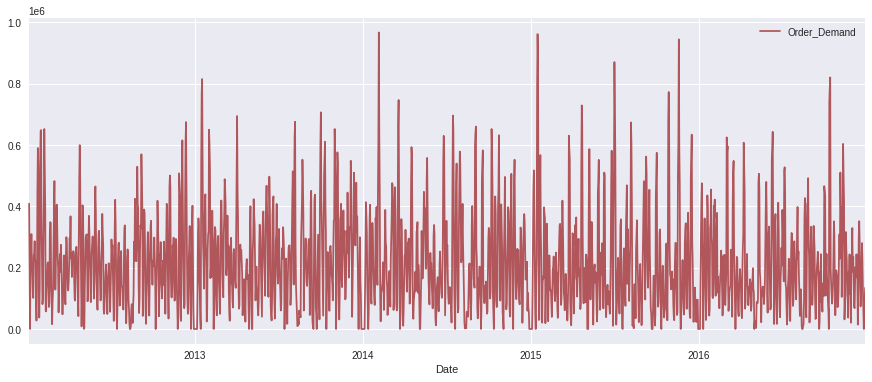

In [117]:
# tail-rolling average transform
rolling = values.rolling(window=3)
rolling_mean = rolling.mean()
values.plot();
rolling_mean.plot(color='#b1565b');


In [118]:
# smoothing moving average data modeling
sma_until_2015 = values['Order_Demand'].loc[:'2016-01-01']
sma_from_2016 = values['Order_Demand'].loc['2016-01-01':]
sma_prediction_3days_mean = rolling_mean['Order_Demand'].loc['2016-01-01':]


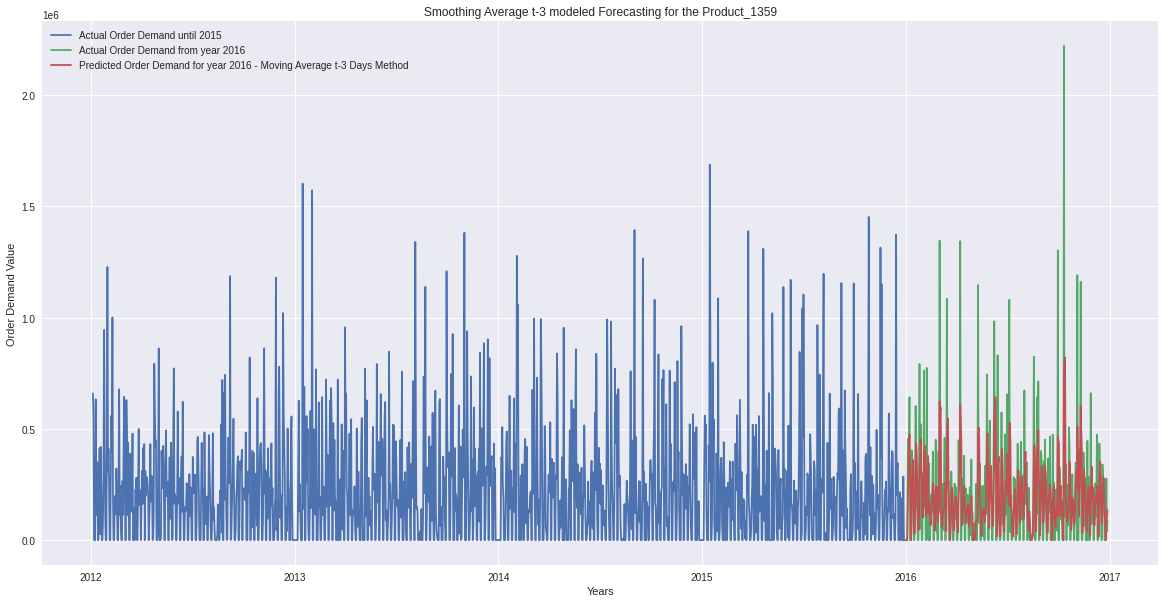

In [119]:
# plot smoothing average t-3 modeled prediction all data
plt.figure(figsize=(20, 10))
plt.title("Smoothing Average t-3 modeled Forecasting for the Product_1359")
plt.plot(sma_until_2015, label='Actual Order Demand until 2015')
plt.plot(sma_from_2016, label='Actual Order Demand from year 2016')
plt.plot(sma_prediction_3days_mean, label='Predicted Order Demand for year 2016 - Moving Average t-3 Days Method')
plt.ylabel('Order Demand Value')
plt.xlabel('Years')
plt.legend(loc="best");


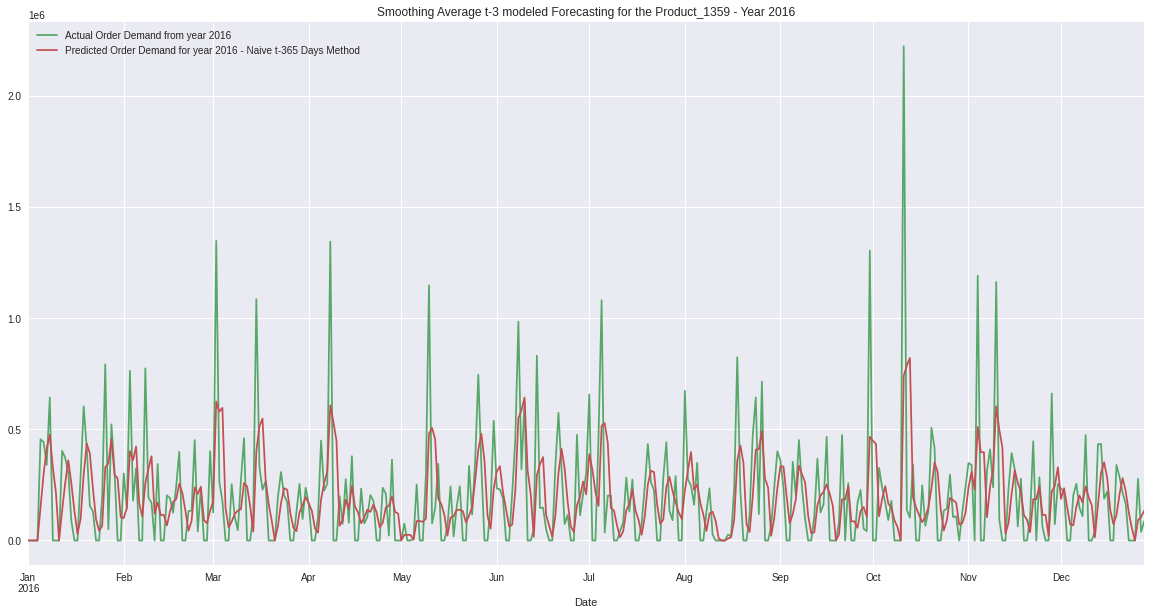

In [120]:
# plot smoothing average t-3 modeled prediction year 2016
plt.title("Smoothing Average t-3 modeled Forecasting for the Product_1359 - Year 2016")
sma_from_2016.plot(figsize=(20,10), color='#56a868', label='Actual Order Demand from year 2016', legend=True);
sma_prediction_3days_mean.plot(label='Predicted Order Demand for year 2016 - Naive t-365 Days Method', color='#c54e52', legend=True);


In [121]:
# prepare data to print related metrics
y_true_sma = sma_from_2016.to_numpy()
y_pred_sma = sma_prediction_3days_mean.to_numpy()
obj0_1 = Metrics(y_true_sma, y_pred_sma)


In [122]:
print(f'MA mase: {obj0_1.mean_absolute_scaled_error(clean=True, decimal=5)}')
print(f'MA rmse: {obj0_1.root_mean_squared_error(clean=True, decimal=5)}')
print(f'MA mae : {obj0_1.mean_absolute_error(clean=True, decimal=5)}')


MA mase: 0.6814
MA rmse: 225083.9659
MA mae : 161075.97341


[>>> Click here to go to index <<<](#index)

<a name='forecasting_xboost'></a>
### Forecasting - XGBoost

In [123]:
# remember chosen product dataframe format
chosen_product


Product_Code Warehouse  Product_Category  ... YearQuarter  YearMonth  DayWeek
0              1359    Whse_J                19  ...      2012-1    2012-01        3
1              1359    Whse_J                19  ...      2012-1    2012-01        3
2              1359    Whse_J                19  ...      2012-1    2012-01        3
3              1359    Whse_J                19  ...      2012-1    2012-01        3
4              1359    Whse_J                19  ...      2012-1    2012-01        3
...             ...       ...               ...  ...         ...        ...      ...
16930          1359    Whse_J                19  ...      2016-4    2016-12        2
16931          1359    Whse_J                19  ...      2016-4    2016-12        2
16932          1359    Whse_J                19  ...      2016-4    2016-12        2
16933          1359    Whse_J                19  ...      2016-4    2016-12        2
16934          1359    Whse_J                19  ...      2016-4    2016-12        2

[16935 rows x 13 columns]

In [124]:
# temporary chosen product dataframe
chosen_product_temp = chosen_product.drop(columns=['Product_Code', 'Warehouse', 'Product_Category', 'YearQuarter', 'YearMonth'])
chosen_product_temp


Date  Order_Demand  Year  Quarter  Month  Week  Day  DayWeek
0     2012-01-05         50000  2012        1      1     1    5        3
1     2012-01-05          5000  2012        1      1     1    5        3
2     2012-01-05          5000  2012        1      1     1    5        3
3     2012-01-05          2000  2012        1      1     1    5        3
4     2012-01-05        300000  2012        1      1     1    5        3
...          ...           ...   ...      ...    ...   ...  ...      ...
16930 2016-12-28          3000  2016        4     12    52   28        2
16931 2016-12-28         13000  2016        4     12    52   28        2
16932 2016-12-28         10000  2016        4     12    52   28        2
16933 2016-12-28          3000  2016        4     12    52   28        2
16934 2016-12-28         11000  2016        4     12    52   28        2

[16935 rows x 8 columns]

In [127]:
# train, validation data set
train = chosen_product_temp[chosen_product_temp['Date'] < '2016-01-01']
val = chosen_product_temp[chosen_product_temp['Date'] >= '2016-01-01']
print(train.shape, val.shape)


(14060, 8) (2875, 8)


In [128]:
# train and test definition
target = 'Order_Demand'
features = chosen_product_temp.drop([target, 'Date'], axis=1).columns
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)


(14060, 6) (14060,)
(2875, 6) (2875,)


In [129]:
# xboost model
xboost_model = make_pipeline(
    SimpleImputer(),
    RobustScaler(),
    XGBRegressor(random_state=1,
                 n_jobs=-1,
                 objective='reg:squarederror',
                 max_depth=5,
                 learning_rate=0.2))

xboost_model.fit(X_train, y_train);


In [130]:
# xboost prediction
y_pred = xboost_model.predict(X_val)


In [131]:
# prepare data to print related metrics
y_true_xboost = y_val.to_numpy()
y_pred_xboost = y_pred
obj3 = Metrics(y_true_xboost, y_pred_xboost)


In [132]:
print(f'xboost mase: {obj3.mean_absolute_scaled_error(clean=True, decimal=5)}')
print(f'xboost rmse: {obj3.root_mean_squared_error(clean=True, decimal=5)}')
print(f'xboost mae : {obj3.mean_absolute_error(clean=True, decimal=5)}')


xboost mase: 0.81589
xboost rmse: 84013.36986
xboost mae : 35448.14165


[>>> Click here to go to index <<<](#index)

<a name='forecasting_analysis'></a>
### Forecasting - Analysis

|   METHOD   |   MASE  |     RMSE     |      MAE     |
|:----------:|:-------:|:------------:|:------------:|
| naïve      | 1.01409 | 405853.3407  | 284522.63374 |
| arima      | 0.61837 | 241853.30245 | 142107.19061 |
| auto arima | 0.68261 | 242612.48257 | 156869.74047 |
| SMA        | 0.6814  | 225083.9659  | 161075.97341 |
| XGBoost    | 0.81589 | 84013.36986  | 35448.14165  |

**Definitions and Considerations:**
- **MASE:** mean absolut scaled error, is a measure of the accuracy of forecasts. All methods have MASE smaller than 1 and that means they are better than naïve forecasting. **ARIMA has the best MASE**.
- **RMSE:** root mean square error, is a technique used to understang the relationship between one or more predictor variables and a response variable. **XGBoost has the lowest RMSE**, this mean that it is able to fit the dataset the best out of the five potential models.
- **MAE:** mean absolute error, is simply, as the name suggests, the mean of the absolute errors. The absolute error is the absolute value of the difference between the forecasted value and the actual value. **XGBoost has the lowest MAE**, this mean that this model has the smallest mean of the absolute errors and it is the best for this accuracy measurement.

**Conclusions:**  
- **XGBoost is the best model** from the 5 models analysis. Probably it is possible to get even better results by trying new models like LSTM or even trying new ways of modeling the existing ones.

[>>> Click here to go to index <<<](#index)